# **GARCH(p,q)** model in *Bollinger's Band* strategy 

---
---
Our goal is to implement GARCH model, which is used to estimate future volatility of an asset. It assumes that daily volatility depends on p past daily volatilities and q past returns from an asset. Then we are going to use it in well-known strategy called *Bollinger's Band* and compare it's performance with strategy using sigma with rolling window. 






Installing packages:


*   *arch*-Python's built-in version of GARCH(p,q)
*   *yfinance*-historical stocks prices
*   *pykalm*-Python's built-in version of Kalman's Filter



In [ ]:
!pip install arch #ARCH for Python's GARCH function
!pip install yfinance #Stock prices
!pip install pykalman #Kalman's filter

     |████████████████████████████████| 902 kB 12.8 MB/s 
     |████████████████████████████████| 9.8 MB 22.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 63 kB 911 kB/s 
     |████████████████████████████████| 6.4 MB 36.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.1

In [ ]:
import pandas as pd
from random import gauss,random
from random import seed
from matplotlib import pyplot
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,pacf
from arch import arch_model
from datetime import datetime
import scipy.optimize as sopt
import yfinance as yf
from scipy.stats import norm
from time import time
import tabulate
from sklearn.model_selection import TimeSeriesSplit
from pykalman import KalmanFilter



Loading NASDAQ companies daily stock prices data (2011-2021) and calculating returns as
$$R_i=\log{\frac{S_{i}}{S_{i-1}}}\cdot 100\%$$
where $i$ is a given day.
We ommited those with shorter history but in general those are the TOP 10 tech-companies in the US.

In [ ]:
end = datetime(2022,1,1).strftime('%Y-%m-%d')
NASDAQ={'AAPL':None,'MSFT':None,'AMZN':None,'GOOGL':None,'TSLA':None,'INTC':None,'NVDA':None,'ADBE':None,'NFLX':None,'CMCSA':None}
for key in NASDAQ.keys():
    data = yf.Ticker(key).history(start = '2011-01-01', end = end, period = '1d')
    NASDAQ[key]=pd.DataFrame({'Zamkniecie' : data["Close"][1:], 'logStopa dzienna': 100* np.log(np.asarray(data['Close'][1:])/np.asarray(data['Close'][:-1]))})
    print(f'{key} with {len(NASDAQ[key])} rows of data')
print(NASDAQ['AAPL'].tail())
print(NASDAQ['AAPL'].head())

AAPL with 2768 rows of data
MSFT with 2768 rows of data
AMZN with 2768 rows of data
GOOGL with 2768 rows of data
TSLA with 2768 rows of data
INTC with 2768 rows of data
NVDA with 2768 rows of data
ADBE with 2768 rows of data
NFLX with 2768 rows of data
CMCSA with 2768 rows of data
            Zamkniecie  logStopa dzienna
Date                                    
2021-12-27  180.100540          2.271486
2021-12-28  179.061859         -0.578392
2021-12-29  179.151749          0.050188
2021-12-30  177.973251         -0.659994
2021-12-31  177.344055         -0.354161
            Zamkniecie  logStopa dzienna
Date                                    
2011-01-04   10.131250          0.520528
2011-01-05   10.214128          0.814716
2011-01-06   10.205870         -0.080890
2011-01-07   10.278961          0.713619
2011-01-10   10.472540          1.865738


Plotting daily closing prices of each company. We can see a strong bullish trend in all of them over years.

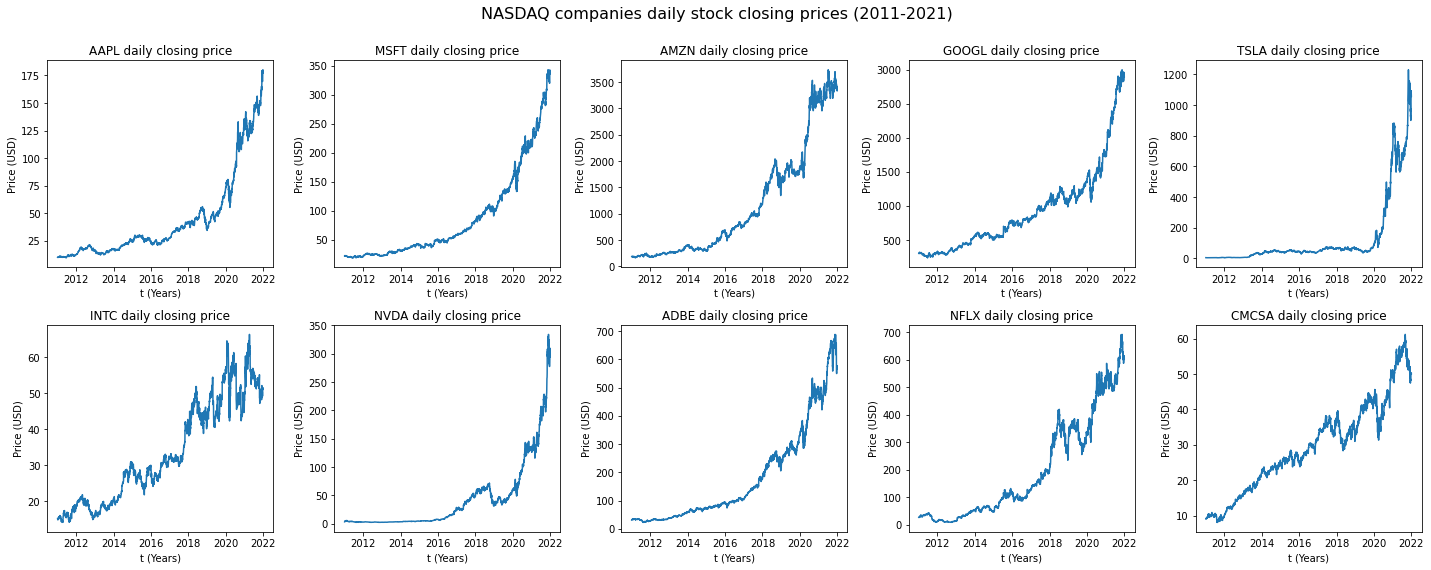

In [ ]:
pyplot.figure(figsize=(20,7.5))
for count, key in enumerate(NASDAQ.keys()):
    pyplot.subplot(2,5,count+1)
    pyplot.plot(NASDAQ[key]['Zamkniecie'])
    pyplot.title(f"{key} daily closing price")
    pyplot.xlabel("t (Years)")
    pyplot.ylabel("Price (USD)")
pyplot.suptitle('NASDAQ companies daily stock closing prices (2011-2021)', fontsize=16,y=1.05)
pyplot.tight_layout()
pyplot.show()

Plotting daily returns (as defined before) of each company. We can see that Tesla and Netflix seems to be the most variable with Comcast being the most stable one.

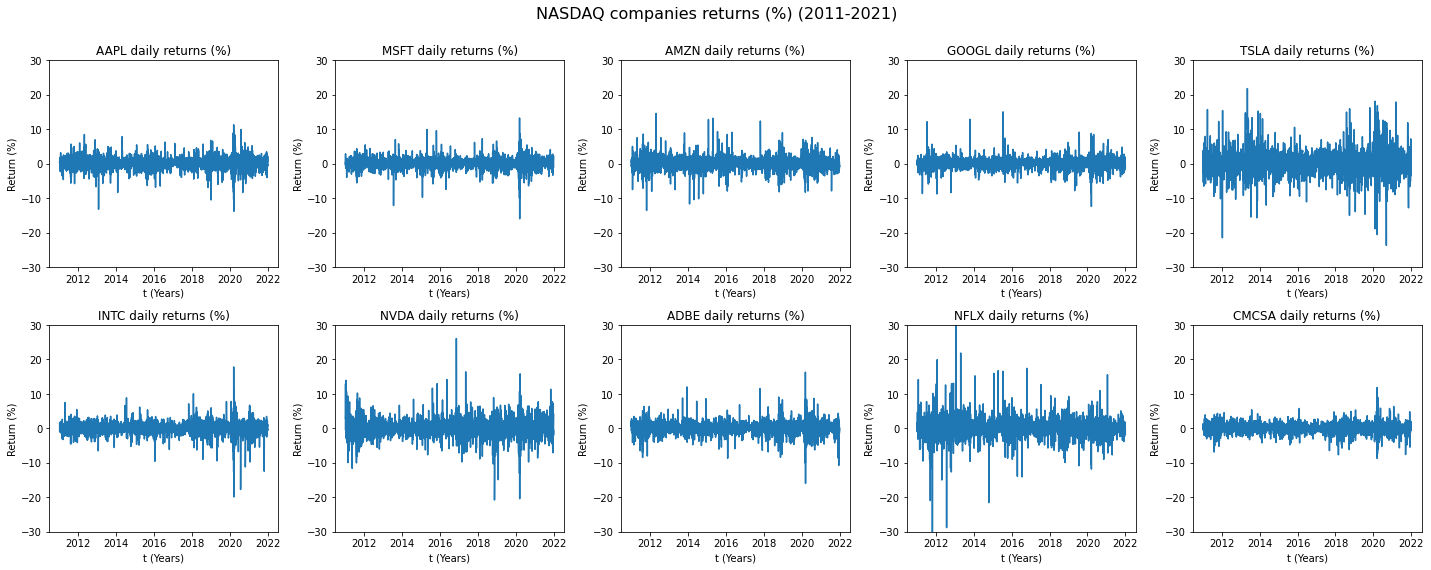

In [ ]:
pyplot.figure(figsize=(20,7.5))
for count, key in enumerate(NASDAQ.keys()):
    pyplot.subplot(2,5,count+1)
    pyplot.plot(NASDAQ[key]['logStopa dzienna'])
    pyplot.title(f"{key} daily returns (%)")
    pyplot.ylim([-30,30])
    pyplot.xlabel("t (Years)")
    pyplot.ylabel("Return (%)")
pyplot.suptitle('NASDAQ companies returns (%) (2011-2021)', fontsize=16,y=1.05)
pyplot.tight_layout()
pyplot.show()

# *Partial autocorrelation plots*
---
We want to check if our data are really suitable for use of GARCH model. It is so if time series are autocorrelated and we can check it by plotting partial autocorrelation functions, which say how much value $S_t$ in time $t$ is depentent from past values $S_{t-1}, S_{t-2}...$. 

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsap

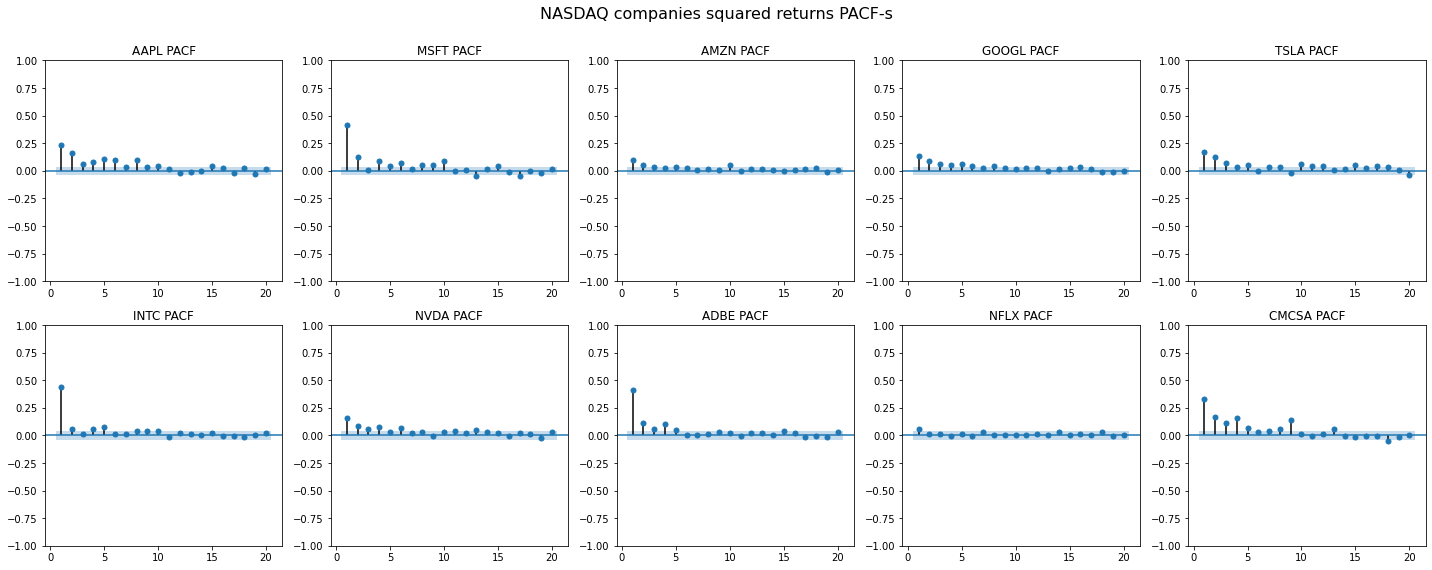

In [ ]:
fig, ax = pyplot.subplots(2,5,figsize=(20,7.5))
for count, key in enumerate(NASDAQ.keys()):
    plot_pacf(NASDAQ[key]['logStopa dzienna']**2,lags=20,ax=ax[count // 5, count % 5],title=f'{key} PACF',alpha=0.05,zero=False)
pyplot.suptitle('NASDAQ companies squared returns PACF-s', fontsize=16,y=1.05)
pyplot.tight_layout()
pyplot.show()

It is clear that with our returns do not depend significantly on lags bigger than 10. Obviously the first lag is the most influencing one and the fifth one seems to be slightly bigger that his neighbours due to the fact that it's exactly week before our return.

# *Logreturn distributions*
---
Now we want to check if returns are really normally distributed which will be assumed by our modelling.  

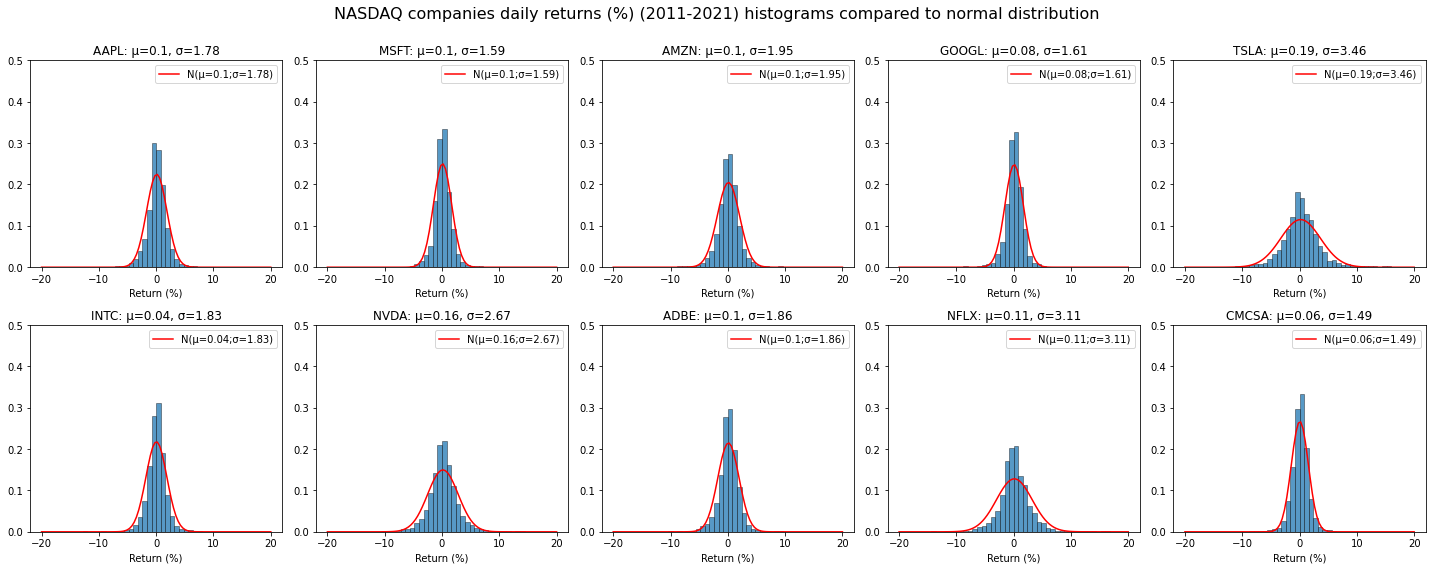

In [ ]:
pyplot.figure(figsize=(20,7.5))
for count, key in enumerate(NASDAQ.keys()):
    data=NASDAQ[key]['logStopa dzienna']
    mu, sd=norm.fit(data)
    x = np.linspace(-20,20, 100)
    p = norm.pdf(x, mu, sd)
    pyplot.subplot(2,5,count+1)
    pyplot.hist(data,density=True,bins=50,range=[-20,20],edgecolor='black', linewidth=0.5,alpha=0.75)
    pyplot.plot(x, p, 'k', linewidth=1.5,color="red",label=f"N(μ={round(mu,2)};σ={round(sd,2)})")
    pyplot.ylim([0,0.5])
    pyplot.title(f"{key}: μ={round(mu,2)}, σ={round(sd,2)}")
    pyplot.xlabel("Return (%)")
    pyplot.legend()
pyplot.suptitle('NASDAQ companies daily returns (%) (2011-2021) histograms compared to normal distribution', fontsize=16,y=1.05)
pyplot.tight_layout()
pyplot.show()

Obviously they histograms are not perfectly Gaussian but there is a clear similarity between them and normal curves of adjusted parametrs. Now we can also confirm our assumptions about Netflix and Testa being the ones with biggest volatility.

To get the idea of GARCH before optimizing it let us focus only on one company data. We're gonna choose Comcast because of its large PACF values on several lags. From now on it will be our sample data set. Therefore we need to divide it into **train** (years 2011-2020) and **test** (2021).

In [ ]:
sample_train = NASDAQ['CMCSA'][:datetime(year=2020,month=12,day=31)]
sample_test= NASDAQ['CMCSA'][datetime(year=2021,month=1,day=1):]
print(sample_train.tail())
print(sample_test.head())

            Zamkniecie  logStopa dzienna
Date                                    
2020-12-24   49.245472          0.677160
2020-12-28   49.959030          1.438585
2020-12-29   50.389118          0.857197
2020-12-30   50.056778         -0.661732
2020-12-31   51.219982          2.297181
            Zamkniecie  logStopa dzienna
Date                                    
2021-01-04   49.372540         -3.673534
2021-01-05   49.077957         -0.598439
2021-01-06   49.647488          1.153779
2021-01-07   49.745686          0.197595
2021-01-08   50.609802          1.722154


# GARCH(p,q)-formula


---

$$\sigma_t^2=\omega + \Sigma_{k=1}^p \alpha_{k} R_{t-k}^2 + \Sigma_{k=1}^q \beta_{k} \sigma_{t-k}^2$$
where
$$R_{n}\sim N(0;\sigma^2_n)$$
and $\sigma_0^2$ is assumed to be $1$ or can be treated as a parameter of the model.
Since the mean of our returns is meant to be $0$ we need to standarize them.Then we calculate GARCH(1,1) parameters on our **train** data using Python's generated function (we will provide our own function later) and compare the results to the historical returns of **test**.



Iteration:      1,   Func. Count:      5,   Neg. LLF: 4335.5064218097705
Iteration:      2,   Func. Count:     13,   Neg. LLF: 4333.925241779408
Iteration:      3,   Func. Count:     20,   Neg. LLF: 4331.121700905099
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4331.015640047635
Iteration:      5,   Func. Count:     32,   Neg. LLF: 4330.363613000149
Iteration:      6,   Func. Count:     37,   Neg. LLF: 4330.311780435731
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4330.299708843716
Iteration:      8,   Func. Count:     47,   Neg. LLF: 4330.2976225638995
Iteration:      9,   Func. Count:     52,   Neg. LLF: 4330.297474253222
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4330.297472303904
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4330.297472302604
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
                       Zero Mean - GARCH Model Results              

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


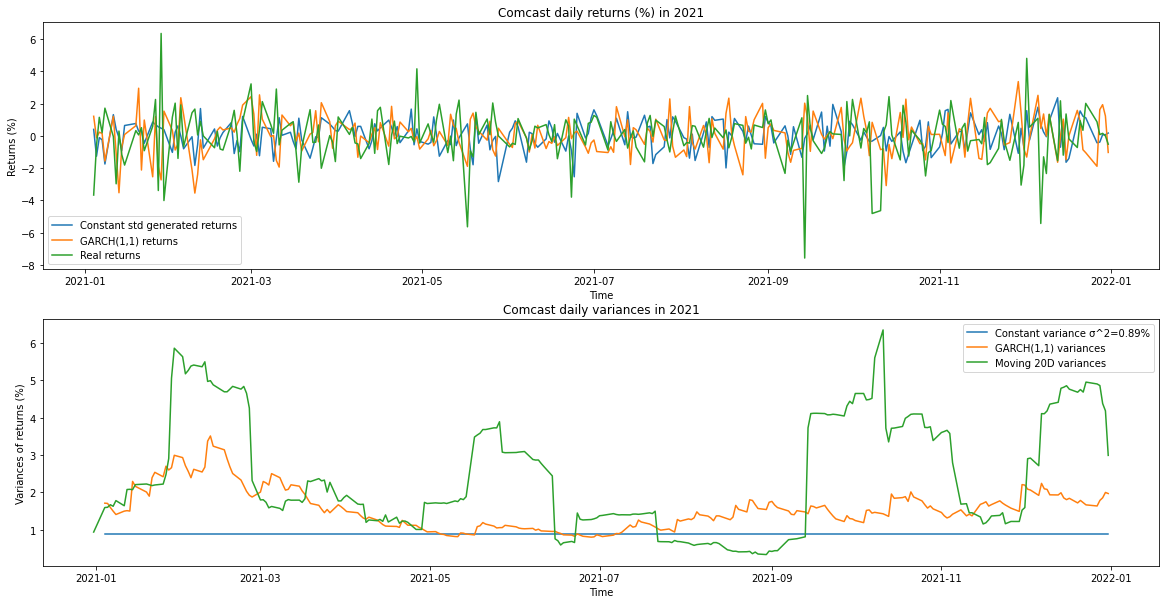

In [ ]:
#First comparitions with Python's GARCH function-returns
returns=sample_train['logStopa dzienna']-np.mean(sample_train['logStopa dzienna'])
##Standard way with constand sd
std_constant=np.std(returns[-20:])
standard=[np.random.normal(loc=0,scale=std_constant,size=1)[0] for i in range(len(sample_test))]
##GARCH(p,q) with Normal distribution
p=1
q=1
model1=arch_model(returns,mean="Zero",vol="GARCH",p=p,q=q)
model1_fit = model1.fit()
print(model1_fit.summary())
yhat1 = model1_fit.forecast(horizon=len(sample_test),method='simulation',simulations=1)
garch_values=yhat1.simulations.values[-1,:][0,:]
garch_variances=yhat1.variance.values[-1,:]
##Plots
pyplot.figure(figsize=(20,10))
pyplot.subplot(2,1,1)
pyplot.plot(sample_test.index,standard)
pyplot.plot(sample_test.index,garch_values)
pyplot.plot(sample_test['logStopa dzienna'])
pyplot.title("Comcast daily returns (%) in 2021")
pyplot.xlabel("Time")
pyplot.ylabel("Returns (%)")
pyplot.legend(['Constant std generated returns',f'GARCH({p},{q}) returns','Real returns'])
########
pyplot.subplot(2,1,2)
pyplot.plot(sample_test.index,np.repeat(std_constant**2,len(sample_test)))
pyplot.plot(sample_test.index,garch_variances)
pyplot.plot(sample_train['logStopa dzienna'][-20:].append(sample_test['logStopa dzienna']).rolling(20).std()**2)
pyplot.title("Comcast daily variances in 2021")
pyplot.xlabel("Time")
pyplot.ylabel("Variances of returns (%)")
pyplot.legend([f'Constant variance σ^2={round(std_constant**2,2)}%',f'GARCH({p},{q}) variances','Moving 20D variances'])


It is important to mention that the variances which were generated with established parameters are based on returns which were alo generated as random normal samples (as earlier formulas suggests) which makes the results almost impossible to match the "actual" variances (here represented by 20 days moving variances). But we can see the main advantage of GARCH model: it usually provides us different stages of volatility in time which is definitely more accurate than treating volatility as a constant parameter (shown as the blue line on the plot above).

Now it is time to calculate our version of GARCH(1,1). We decided to do it from scratch, therefore we calculated *Negative LogLikehood* function and all of it's derivatives (over $\omega, \alpha_1, \beta_1, \sigma_0^2$) by hand. We won't provide the exact formulas in this Notebook (the margin is too small as someone once said) but if anyone's interested let us know or extract them from the numpy calculations.\
* *compute_garch()* calculates us the $\sigma^2$-s for given parameters and returns data;\
* *nll()* computes the nll and the gradient vector





In [ ]:
### GARCH(1,1)
#tutaj obliczamy sobie przyszłe sigmy jak już mamy parametry i podajemy do tego tą początkową sigmę
def compute_garch(a0, a1, b1, returns, sigma0_2):
  horizon = len(returns)
  sigma_2 = np.zeros(horizon)
  sigma_2[0] = sigma0_2
  for i in range(1, horizon):
    sigma_2[i] = a0 + a1 * returns[i-1]**2 + b1 * sigma_2[i-1]
  return sigma_2

#chcemy minimalizować nll na parametrach (a0,a1,b1,sigma0_2) 
def nll(Theta,returns,verbose=False,plots=False):
  t0=time()
  a0 = Theta[0]
  a1 = Theta[1]
  b1 = Theta[2]
  sigma0_2 = Theta[3]
  sigma_2 = compute_garch(a0,a1,b1,returns,sigma0_2)
  t = len(returns)
  nll = 1/2*(t*np.log(2*np.pi)+np.sum(np.log(sigma_2)+(returns**2)/sigma_2))
  nllover_sigma2=np.array([np.sum((b1**np.arange(0,t-i))*(1/sigma_2[i:]-(returns**2)[i:]/(sigma_2**2)[i:])) for i in range(0,t+1)])
  over_a0=np.append([0],np.cumsum(b1**np.arange(0,t)))
  over_sigma0_2=b1**np.arange(0,t+1)
  over_a1=np.append([0],[np.sum(np.flip((returns[:i])**2)*(b1**np.arange(0,i))) for i in range(1,t+1)])
  #over_a1=np.append([0],np.flip(returns**2)@np.matrix(([[0 for k in range(m,t)]+[b1**k for k in range(0,m)] for m in range(1,t+1)])).T)
  over_b1=a0*np.append([0,0],np.cumsum(np.arange(1,t)*(b1**np.arange(0,t-1))))+sigma0_2*np.append([0],np.arange(1,t+1)*(b1**np.arange(0,t)))+a1*np.append([0,0],[np.sum(np.flip((returns[:(i-1)])**2)*(np.arange(1,i)*(b1**np.arange(0,(i-1))))) for i in range(2,t+1)])
  #over_b1=a0*np.append([0,0],np.cumsum(np.arange(1,t)*(b1**np.arange(0,t-1))))+sigma0_2*np.append([0],np.arange(1,t+1)*(b1**np.arange(0,t)))+a1*np.append([0,0],np.flip(returns**2)[1:]@np.matrix(([[0 for k in range(m,t-1)]+[(k+1)*(b1**k) for k in range(0,m)] for m in range(1,t)])).T)
  grad = np.reshape(nllover_sigma2,(1,t+1)) @ (np.array([over_a0,over_a1,over_b1,over_sigma0_2]).T)/(10**2)
  if verbose:
      print(f'NLL:{nll},Theta:{Theta},adjusted grad:{grad}')
  t1=time()
  if plots:
    global NLL_over_iters_bh
    NLL_over_iters_bh+=[nll]
    global time_over_iters_bh
    time_over_iters_bh+=[time_over_iters_bh[-1]+t1-t0]
  ################################
  return nll,np.reshape(grad,Theta.shape)

Here are the first computations (go for a walk or sth cause they are quite slow- around 25 minutes) on our sample **train**.

In [ ]:
NLL_over_iters_bh=[]
time_over_iters_bh=[0]
Theta0 = [1,1,1,1]
t0=time()
ThetaOpt = sopt.fmin_l_bfgs_b(
    lambda Theta: nll(Theta, returns,verbose=True,plots=True),x0=Theta0,bounds=((0.01,2),(0.01,1),(0.01,1),(0.01,2)),pgtol=1e-15,maxfun=200)
t1=time()
print(ThetaOpt[0])
print(f"Time spend:{t1-t0} s")

NLL:12281.473341821584,Theta:[1. 1. 1. 1.],adjusted grad:[[5.44621620e+03 1.09052534e+04 9.38588742e+06 8.51133010e+00]]
NLL:134730.12512237832,Theta:[0.01 0.01 0.01 0.01],adjusted grad:[[-1.93941493e+05 -8.60926888e+04 -8.09069715e+03 -7.69953392e+00]]
NLL:4862.885059300739,Theta:[0.67355984 0.67355984 0.67355984 0.67355984],adjusted grad:[[3.15245934e+01 4.41780395e+01 1.61374574e+02 3.55428404e-02]]
NLL:4862.849151077444,Theta:[0.6735479  0.67354746 0.67355162 0.67354899],adjusted grad:[[3.15235499e+01 4.41764461e+01 1.61361742e+02 3.55418993e-02]]
NLL:4862.705530672186,Theta:[0.67350012 0.67349794 0.67351871 0.67350558],adjusted grad:[[3.15193760e+01 4.41700729e+01 1.61310424e+02 3.55381354e-02]]
NLL:4862.131248847442,Theta:[0.67330902 0.67329987 0.6733871  0.67333196],adjusted grad:[[3.15026800e+01 4.41445830e+01 1.61105289e+02 3.55230825e-02]]
NLL:4859.8373176282075,Theta:[0.67254463 0.67250756 0.67286066 0.67263747],adjusted grad:[[3.14358922e+01 4.40426692e+01 1.60286952e+02 3.

Well, that took its time. The main issue is the derivatives calculation. Also: that was only GARCH(1,1), what about higher $p$ and $q$?\
That's why we came up with the idea of more general approach to GARCH- using scipy derivatives approximations rather than calculating them by hand.
* *compute_general_garch()* computes $\sigma^2$-s as before but also for higher $p$ and $q$ (up to $20$ we believe);
* *nll_value()* calculates NLL;
* *nll_grad()* provides function for all gradients on given returns data, now it can be used for changing parameters without repeating derivations
* *gradient_descent()* uses functions above to provide nll and gradient vector (there was a plan to standarize the $\alpha$-s and $\beta$-s such that they all sum up to $1$ but we decided to give them more freedom- that's why this part is hashed)

In [ ]:
#BRAND NEW GARCH(p,q)
import scipy.misc as misc
def compute_general_garch(Theta,returns,p=1,q=1,forecast=False,historical=None):
  a0=Theta[0]
  alphas=Theta[1:(p+1)]
  alphas=np.flip(alphas)
  betas=Theta[(p+1):(-1)]
  betas=np.flip(betas)
  sigma0_2=Theta[-1]
  horizon = len(returns)
  sigma_2 = np.zeros(horizon)
  if not forecast:
      sigma_2[0]=sigma0_2
      returns=np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]+list(returns))
      sigma_2=np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]+list(sigma_2))
  else:
    returns=np.array(list(historical[-20:])+list(returns))
    sigma_2=np.array(list((historical[-20:])**2)+list(sigma_2)) 
  for i in range(1, horizon):
    sigma_2[i+20] = a0 + np.sum(alphas* (returns[(i-p+20):(i+20)])**2) + np.sum(betas * sigma_2[(i-q+20):(i+20)])
  return sigma_2[20:]

def nll_value(Theta,returns,p,q):
  sigma_2 = compute_general_garch(Theta,returns,p,q)
  t = len(returns)
  nll_value = 1/2*(t*np.log(2*np.pi)+np.sum(np.log(sigma_2)+(returns**2)/sigma_2))
  return nll_value

def nll_grad(returns,p,q):
    return lambda Theta: np.array([misc.derivative(lambda x: nll_value(Theta[:k]+[x]+Theta[(k+1):],returns,p,q),x0=Theta[k],dx=1e-05) for k in range(len(Theta))])

def gradient_descent(Theta,returns,grad_f,p,q, verbose = False,plots=False):
  t0=time()
  #zbicie do a1+...ap+b1+...bp=1
  #norm=np.sum(Theta[1:(-1)])
  #Theta[1:(-1)]=Theta[1:(-1)]/norm
  #sigma_2 = compute_general_garch(Theta,returns,p,q)
  t = len(returns)
  nll= nll_value(Theta,returns,p,q)
  grad=grad_f(list(Theta))
  if verbose:
    print(f'NLL:{nll},Theta:{Theta},adjusted grad:{grad}')
  t1=time()
  if plots:
    global NLL_over_iters_pd
    NLL_over_iters_pd+=[nll]
    global time_over_iters_pd
    time_over_iters_pd+=[time_over_iters_pd[-1]+t1-t0]
    global a0_over_iters_pd
    a0_over_iters_pd+=[Theta[0]]
    global a1_over_iters_pd
    a1_over_iters_pd+=[Theta[1]]
    global b1_over_iters_pd
    b1_over_iters_pd+=[Theta[2]]
    global sigma02_over_iters_pd
    sigma02_over_iters_pd+=[Theta[3]]
  ##########################
  return nll,np.reshape(grad,Theta.shape)


Let us check how fast this bad boy is...

In [ ]:
NLL_over_iters_pd=[]
time_over_iters_pd=[0]
a0_over_iters_pd=[]
a1_over_iters_pd=[]
b1_over_iters_pd=[]
sigma02_over_iters_pd=[]
#GARCH parameters
p=1
q=1
#Sample Theta
Theta0 = [1]+[1]+[0.001 for i in range(p-1)]+[1]+[0.001 for i in range(q-1)]+[1]
#set timer
t0=time()
#Grad function for our returns (depending on current Theta)
grad_f=nll_grad(returns,p,q)
bounds=[(0.01,2)]+[(0.01,1)]+[(0.001,0.4) for i in range(p-1)]+[(0.01,1)]+[(0.001,0.4) for i in range(q-1)]+[(0.01,2)]
ThetaOpt = sopt.fmin_l_bfgs_b(
    lambda Theta: gradient_descent(Theta, returns,grad_f,p,q,verbose=True,plots=True),x0=Theta0,bounds=bounds,pgtol=1e-30,maxfun=200,factr=10,epsilon=1e-16)
t1=time()
print(f"Time spend:{t1-t0} s")
print(f"Our GARCH parameters:\nomega        {round(ThetaOpt[0][0],6)}\nalpha[1]     {round(ThetaOpt[0][1],6)}\nbeta[1]      {round(ThetaOpt[0][2],6)}\nsigma0^2     {round(ThetaOpt[0][3],6)}\n\nPython's GARCH parameters:\n{model1_fit.params}")

NLL:12281.474189157383,Theta:[1. 1. 1. 1.],adjusted grad:[4.23483572e+02 8.29748592e+02 8.16743888e+05 2.08259335e+00]
NLL:134730.1284461242,Theta:[0.01 0.01 0.01 0.01],adjusted grad:[-9.60018843e+06 -4.00040067e+06 -4.01195713e+05 -3.16066439e+02]
NLL:4433.748991602317,Theta:[0.46299148 0.46299148 0.46299148 0.46299148],adjusted grad:[-34.16455343 192.49253401 -90.01718822   0.67524234]
NLL:4433.704249264209,Theta:[0.46286431 0.46271511 0.46294641 0.46284135],adjusted grad:[-34.85392608 191.91984757 -91.46685697   0.67518022]
NLL:4433.528400093262,Theta:[0.46235567 0.46160966 0.46276615 0.46224086],adjusted grad:[-37.62274414 189.61784808 -97.27507409   0.67493029]
NLL:4432.875489488443,Theta:[0.46032107 0.45718786 0.46204509 0.4598389 ],adjusted grad:[ -48.88162648  180.2270333  -120.66196391    0.67390483]
NLL:4427.56967786052,Theta:[0.45909714 0.40869975 0.45582553 0.44101557],adjusted grad:[-136.36264102   92.47406297 -302.52615124    0.6884241 ]
NLL:4422.6589923951315,Theta:[0.48

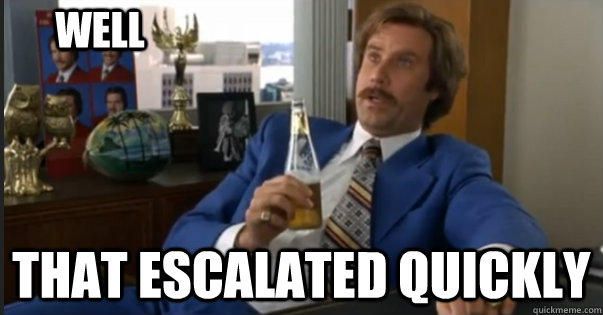

First of all: the parameters we got and the minimum NLL are pretty much the same as the built-in GARCH results (besides $\sigma_0^2$ which is not a parameter of that one). Actually our NLL turned out to be even smaller!\
But how fast was it shrinking that pesky NLL in comparition to the first GARCH(1,1) we've created (the so called *by-hand* method)? Let us find out on the following plots:

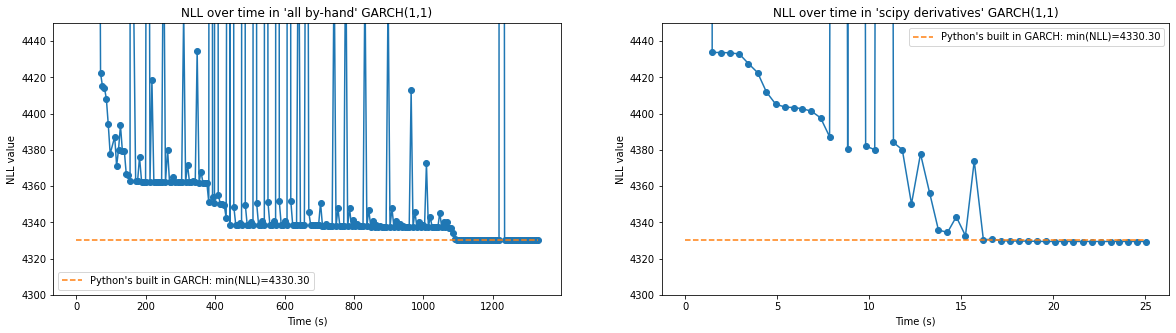

In [ ]:
pyplot.figure(figsize=(20,5))
pyplot.subplot(1,2,1)
pyplot.plot(time_over_iters_bh[1:],NLL_over_iters_bh,marker='o')
pyplot.plot(time_over_iters_bh,np.repeat(4330.30,len(time_over_iters_bh)),label="Python's built in GARCH: min(NLL)=4330.30",linestyle='--')
pyplot.ylim([4300,4450])
pyplot.title("NLL over time in 'all by-hand' GARCH(1,1)")
pyplot.xlabel("Time (s)")
pyplot.ylabel("NLL value")
pyplot.legend()
pyplot.subplot(1,2,2)
pyplot.plot(time_over_iters_pd[1:],NLL_over_iters_pd,marker='o')
pyplot.plot(time_over_iters_pd,np.repeat(4330.30,len(time_over_iters_pd)),label="Python's built in GARCH: min(NLL)=4330.30",linestyle='--')
pyplot.ylim([4300,4450])
pyplot.title("NLL over time in 'scipy derivatives' GARCH(1,1)")
pyplot.xlabel("Time (s)")
pyplot.ylabel("NLL value")
pyplot.legend()

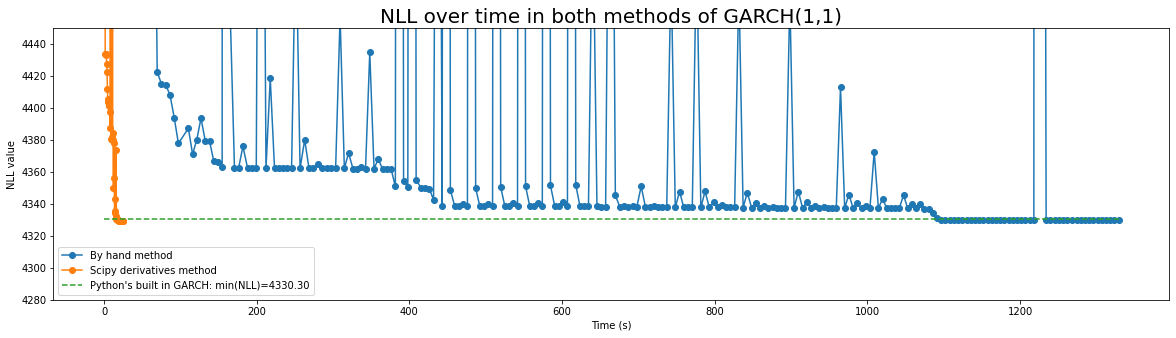

In [ ]:
pyplot.figure(figsize=(20,5))
pyplot.plot(time_over_iters_bh[1:],NLL_over_iters_bh,marker='o',label="By hand method")
pyplot.plot(time_over_iters_pd[1:],NLL_over_iters_pd,marker='o',label="Scipy derivatives method")
pyplot.plot(time_over_iters_bh,np.repeat(4330.30,len(time_over_iters_bh)),label="Python's built in GARCH: min(NLL)=4330.30",linestyle='--')
pyplot.ylim([4280,4450])
pyplot.title("NLL over time in both methods of GARCH(1,1)",size=20)
pyplot.xlabel("Time (s)")
pyplot.ylabel("NLL value")
pyplot.legend()

The new one is a lot faster and as we said earlier it is more generic. From now on we're gonna be using only this one.\
We saw how NLL changes in time but what about the parameters that we're trying to optimize? Here are more plots!

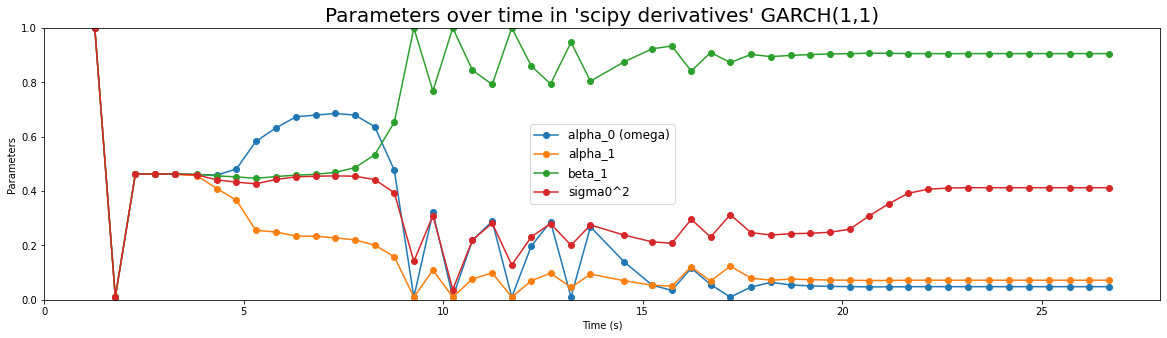

In [ ]:
pyplot.figure(figsize=(20,5))
pyplot.plot(time_over_iters_pd[1:],a0_over_iters_pd,marker='o',label="alpha_0 (omega)")
pyplot.plot(time_over_iters_pd[1:],a1_over_iters_pd,marker='o',label="alpha_1")
pyplot.plot(time_over_iters_pd[1:],b1_over_iters_pd,marker='o',label="beta_1")
pyplot.plot(time_over_iters_pd[1:],sigma02_over_iters_pd,marker='o',label="sigma0^2")
pyplot.ylim([0,1])
pyplot.title("Parameters over time in 'scipy derivatives' GARCH(1,1)",size=20)
pyplot.xlabel("Time (s)")
pyplot.ylabel("Parameters")
pyplot.legend(prop={'size': 12})

What is kind of fascinating for us, it the fact how $\alpha_1$ and $\beta_1$ sort of "mirror" their behavior. It is also interesting how Python's function for gradient descent jumps between higher and lower values to finally stay on some value. If it wasn't for $\sigma_0^2$ the calculations would be even faster- it was the last one to be set.

Since the parameters we got are practically identical to the ones of built-in GARCH, we won't compare again the generated $\sigma^2$-s to the actual variances of 2021. What we can do instead is to see how well is our GARCH(1,1) doing on the exact same set that we optimized the parameters on. This time instead of generating returns, we're gonna use the actual historical ones and just calculate the volatilities from the parameters optimized earlier.

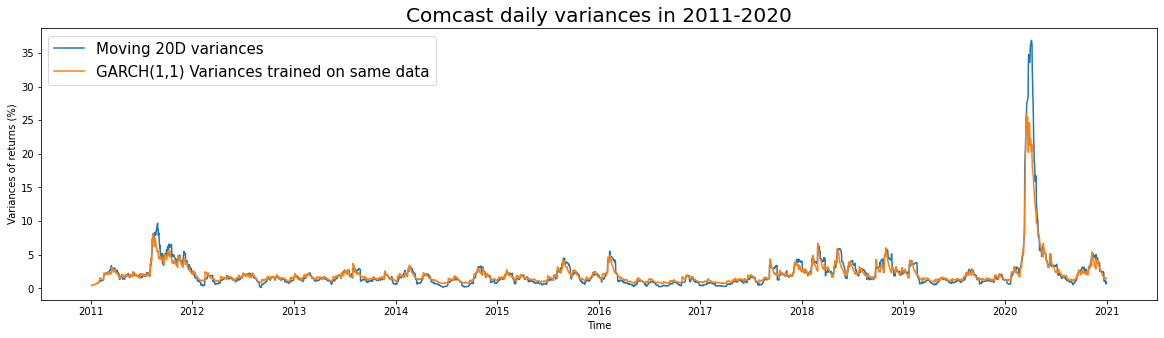

In [ ]:
pyplot.figure(figsize=(20,5))
sigmas_2=compute_general_garch(ThetaOpt[0],returns,p=1,q=1)
#pyplot.plot(returns**2,label="Squared real returns")
pyplot.plot(sample_train.index,returns.rolling(20).std()**2,label="Moving 20D variances")
pyplot.plot(sample_train.index,sigmas_2,label="GARCH(1,1) Variances trained on same data")
pyplot.title("Comcast daily variances in 2011-2020",size=20)
pyplot.xlabel("Time")
pyplot.ylabel("Variances of returns (%)")
pyplot.legend(prop={'size': 15})


It's clear that since GARCH was only calculating the volatilities on given data, the results are almost perfectly matching the actual variances represented here again by 20 days moving variance.

Since Python's GARCH did it, we also can forecast the actual returns just from the parameters.\
This is what *symulate_general_garch()* does (if *forecast* is true then the simulation also requires last values before the given data to establish the first few $\sigma^2$-s, otherwise it just takes $0$ as those previous ones).

In [ ]:
#Simulate GARCHian variances and guess what GARCH is it-comparition
def symulate_general_garch(Theta, n,p=1,q=1,forecast=False,historical=None,sigma0_2=None):
  a0=Theta[0]
  alphas=Theta[1:(p+1)]
  alphas=np.flip(alphas)
  betas=Theta[(p+1):(-1)]
  betas=np.flip(betas)
  sigma_2 = np.zeros(n)
  returns=np.zeros(n)
  if not sigma0_2:
      sigma0_2=Theta[-1]
  if not forecast:
    r_0=np.random.normal(scale=np.sqrt(sigma0_2),size=1)
    returns=np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,float(r_0)]+list(returns))
    sigma_2=np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,float(sigma0_2)]+list(sigma_2)) 
  else:
    returns=np.array(list(historical[-20:])+list(returns))
    sigma_2=np.array(list((historical[-20:])**2)+list(sigma_2)) 
  for i in range(0, n):
    sigma_2[i+20] = a0 + np.sum(alphas* (returns[(i-p+20):(i+20)])**2) + np.sum(betas * sigma_2[(i-q+20):(i+20)])
    returns[i+20] = np.random.normal(scale=np.sqrt(sigma_2[i+20]),size=1)
  return returns[20:],sigma_2[20:]

Real data won't tell us exactly which parameters of GARCH approach are the ideal ones (if they even exists) but we can generate our own GARCH data on some made up parameters and check how accurate would our function be to sort of guess them. This is what we do in the following cell:

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1000.1466837784708
Iteration:      2,   Func. Count:     11,   Neg. LLF: 990.9062733147025
Iteration:      3,   Func. Count:     18,   Neg. LLF: 990.8496518369653
Iteration:      4,   Func. Count:     24,   Neg. LLF: 989.9993768319349
Iteration:      5,   Func. Count:     30,   Neg. LLF: 988.6591279917805
Iteration:      6,   Func. Count:     37,   Neg. LLF: 988.5058654739867
Iteration:      7,   Func. Count:     42,   Neg. LLF: 988.4893776726319
Iteration:      8,   Func. Count:     47,   Neg. LLF: 988.488980394512
Iteration:      9,   Func. Count:     52,   Neg. LLF: 988.4889728793191
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 988.4889728799017
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
Real GARCH parameters:
omega        0.06
alpha[1]     0.37
beta[1]      0.21
sigma0^2     0.3

Our GARCH parameters:

omega        0.071768
alph

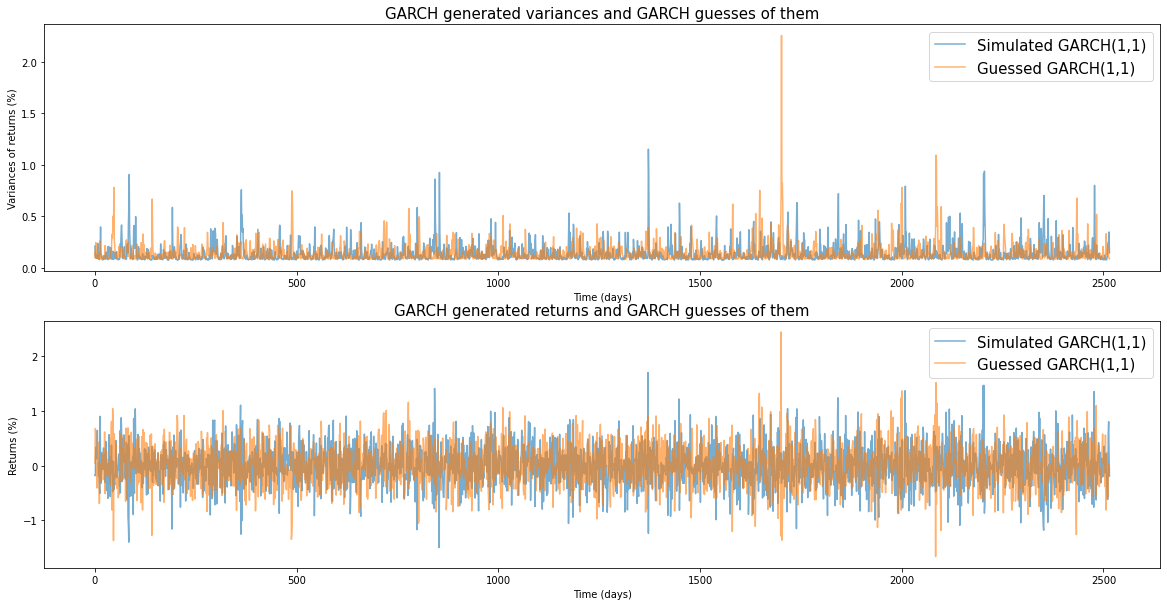

In [ ]:
#GARCH parameters
p=1
q=1
Theta_sym = [0.06]+[0.37]+[0.005 for i in range(p-1)]+[0.21]+[0.005 for i in range(q-1)]+[0.3]
sym_returns,sym_sigmas2=symulate_general_garch(Theta_sym,len(sample_train),p=p,q=q)
#Sample Theta
Theta0 = [1]+[1]+[0.001 for i in range(p-1)]+[1]+[0.001 for i in range(q-1)]+[1]
#Grad function for our returns (depending on current Theta)
grad_f=nll_grad(sym_returns,p,q)
bounds=[(0.01,2)]+[(0.01,1)]+[(0.001,0.4) for i in range(p-1)]+[(0.01,1)]+[(0.001,0.4) for i in range(q-1)]+[(0.01,1)]
Theta_check = sopt.fmin_l_bfgs_b(
    lambda Theta: gradient_descent(Theta, sym_returns,grad_f,p,q,verbose=False,plots=False),x0=Theta0,bounds=bounds,pgtol=1e-30,maxfun=200,factr=10,epsilon=1e-16)
model_check = arch_model(sym_returns ,mean="Zero",vol="GARCH",p=p,q=q)
model_check_fit = model_check.fit()
print(f"""Real GARCH parameters:
omega        {Theta_sym[0]}
alpha[1]     {Theta_sym[1]}
beta[1]      {Theta_sym[2]}
sigma0^2     {Theta_sym[3]}

Our GARCH parameters:\n
omega        {round(Theta_check[0][0],6)}
alpha[1]     {round(Theta_check[0][1],6)}
beta[1]      {round(Theta_check[0][2],6)}
sigma0^2     {round(Theta_check[0][3],6)}

Python's GARCH parameters:\n{model_check_fit.params}""")
our_returns, our_sigmas2=symulate_general_garch(Theta_check[0],len(sample_train),p=p,q=q)
pyplot.figure(figsize=(20,10))
pyplot.subplot(2,1,1)
pyplot.plot(sym_sigmas2,label=f"Simulated GARCH({p},{q})",alpha=0.6)
pyplot.plot(our_sigmas2,label=f"Guessed GARCH({p},{q})",alpha=0.6)
pyplot.title("GARCH generated variances and GARCH guesses of them",size=15)
pyplot.xlabel("Time (days)")
pyplot.ylabel("Variances of returns (%)")
pyplot.legend(prop={'size': 15})
pyplot.subplot(2,1,2)
pyplot.plot(sym_returns,label=f"Simulated GARCH({p},{q})",alpha=0.6)
pyplot.plot(our_returns,label=f"Guessed GARCH({p},{q})",alpha=0.6)
pyplot.title("GARCH generated returns and GARCH guesses of them",size=15)
pyplot.xlabel("Time (days)")
pyplot.ylabel("Returns (%)")
pyplot.legend(prop={'size': 15})


The guessed parameters were kind of close to the actual ones. We got to keep in mind that the GARCH generated data is not deterministic, returns are just normal samples, therefore we should not expect perfect match which makes the results suprisingly well. When it comes to the plots above the range of both returns and variances values is very similar.

Enough of that Comcast product placement, let's come back to all 10 of our tech-giants.
Imagine we are half way through 2021 and need to calculate next day's volatility. There would be no point in generating returns up to that day and calculate $\sigma_{t+1}^2$ from them since we have the actual data. Let's consider GARCH variances in 2021 calculated from the actual returns of that year with parameters trained on 2011-2021. It's gonna be the basic idea behind our way of comparing GARCH(p,q) results later. Here are the plots of how were each company 2021 volatilities predicted on the actual returns.

Calculating AAPL...
Calculating MSFT...
Calculating AMZN...
Calculating GOOGL...
Calculating TSLA...
Calculating INTC...
Calculating NVDA...
Calculating ADBE...
Calculating NFLX...
Calculating CMCSA...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


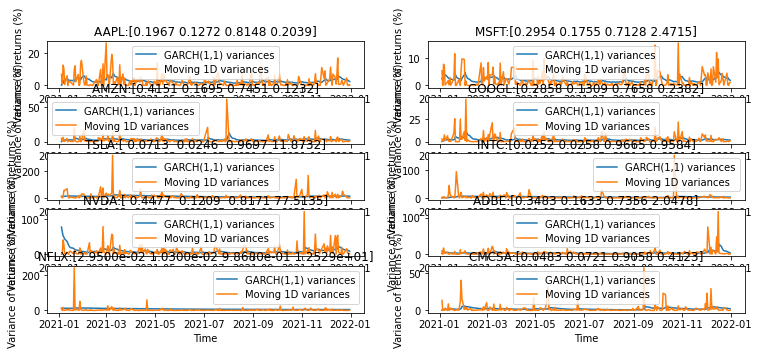

|    | Ticker   |     omega |   alpha_1 |   beta_1 |   sigma0^2 |
|---:|:---------|----------:|----------:|---------:|-----------:|
|  0 | AAPL     | 0.196707  | 0.127206  | 0.814792 |   0.203925 |
|  1 | MSFT     | 0.295428  | 0.175538  | 0.712803 |   2.47148  |
|  2 | AMZN     | 0.415061  | 0.169459  | 0.745146 |   0.123233 |
|  3 | GOOGL    | 0.285764  | 0.130893  | 0.765764 |   0.238151 |
|  4 | TSLA     | 0.0712826 | 0.0246351 | 0.969709 |  11.8732   |
|  5 | INTC     | 0.0251761 | 0.0258159 | 0.966535 |   0.958444 |
|  6 | NVDA     | 0.447712  | 0.120946  | 0.81713  |  77.5135   |
|  7 | ADBE     | 0.348283  | 0.163279  | 0.735602 |   2.04782  |
|  8 | NFLX     | 0.029492  | 0.0102965 | 0.986813 |  12.529    |
|  9 | CMCSA    | 0.0482595 | 0.0720549 | 0.905765 |   0.412329 |
Calculating AAPL...
Calculating MSFT...
Calculating AMZN...
Calculating GOOGL...
Calculating TSLA...
Calculating INTC...


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/scipy/misc/common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  val += weights[k]*func(x0+(k-ho)*dx,*args)


Calculating NVDA...
Calculating ADBE...
Calculating NFLX...
Calculating CMCSA...


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/scipy/misc/common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  val += weights[k]*func(x0+(k-ho)*dx,*args)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


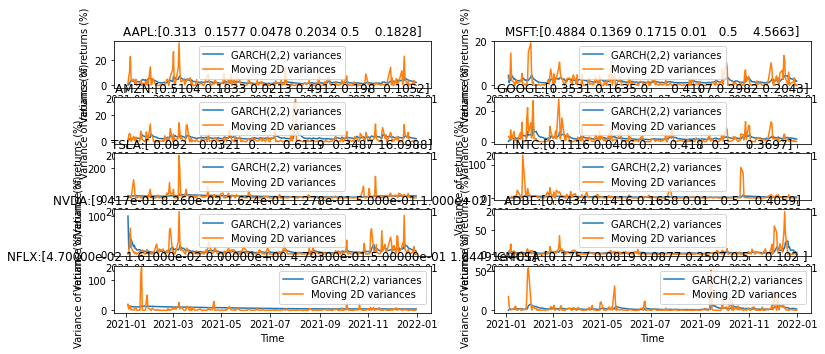

|    | Ticker   |     omega |   alpha_1 |   alpha_2 |   beta_1 |   beta_2 |   sigma0^2 |
|---:|:---------|----------:|----------:|----------:|---------:|---------:|-----------:|
|  0 | AAPL     | 0.312993  | 0.15768   | 0.0478026 | 0.203395 | 0.5      |   0.182783 |
|  1 | MSFT     | 0.488391  | 0.136919  | 0.171516  | 0.01     | 0.5      |   4.56631  |
|  2 | AMZN     | 0.510414  | 0.183289  | 0.0212578 | 0.491244 | 0.198015 |   0.105238 |
|  3 | GOOGL    | 0.353085  | 0.163506  | 0         | 0.410654 | 0.298193 |   0.20432  |
|  4 | TSLA     | 0.0919637 | 0.0321103 | 0         | 0.611881 | 0.348658 |  16.0988   |
|  5 | INTC     | 0.11159   | 0.0406129 | 0         | 0.417999 | 0.5      |   0.36973  |
|  6 | NVDA     | 0.941664  | 0.0826246 | 0.162432  | 0.127767 | 0.5      | 100        |
|  7 | ADBE     | 0.643421  | 0.141558  | 0.165833  | 0.01     | 0.5      |   0.405914 |
|  8 | NFLX     | 0.0469795 | 0.0161181 | 0         | 0.479298 | 0.5      |  18.4491   |
|  9 | CMCSA    | 0.1

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/scipy/misc/common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  val += weights[k]*func(x0+(k-ho)*dx,*args)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Calculating NVDA...
Calculating ADBE...
Calculating NFLX...
Calculating CMCSA...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


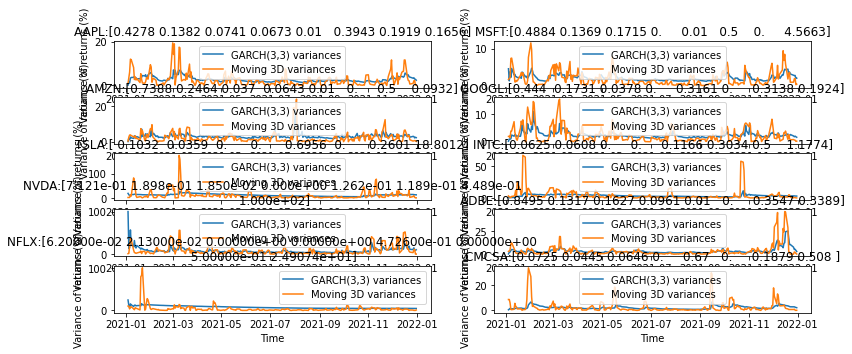

|    | Ticker   |     omega |   alpha_1 |   alpha_2 |     alpha_3 |   beta_1 |   beta_2 |   beta_3 |    sigma0^2 |
|---:|:---------|----------:|----------:|----------:|------------:|---------:|---------:|---------:|------------:|
|  0 | AAPL     | 0.427814  | 0.138156  | 0.0741001 | 0.0673371   | 0.01     | 0.394276 | 0.191885 |   0.165586  |
|  1 | MSFT     | 0.488391  | 0.136919  | 0.171516  | 0           | 0.01     | 0.5      | 0        |   4.56631   |
|  2 | AMZN     | 0.738834  | 0.246368  | 0.0370188 | 0.0643428   | 0.01     | 0        | 0.5      |   0.0931764 |
|  3 | GOOGL    | 0.443987  | 0.173123  | 0.0378362 | 0           | 0.316054 | 0        | 0.313814 |   0.192355  |
|  4 | TSLA     | 0.103236  | 0.03592   | 0         | 0           | 0.695611 | 0        | 0.260123 |  18.8012    |
|  5 | INTC     | 0.0625156 | 0.0607677 | 0         | 0           | 0.116555 | 0.303409 | 0.5      |   1.17737   |
|  6 | NVDA     | 0.712111  | 0.189771  | 0.0185331 | 4.15344e-05 | 0.126224 | 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


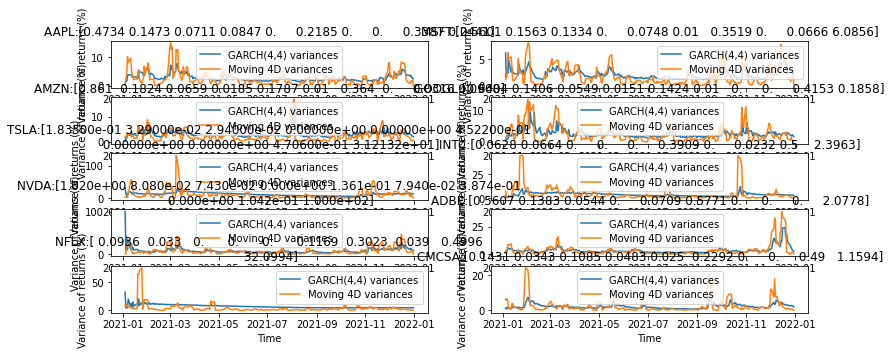

|    | Ticker   |     omega |   alpha_1 |   alpha_2 |   alpha_3 |   alpha_4 |    beta_1 |   beta_2 |    beta_3 |    beta_4 |    sigma0^2 |
|---:|:---------|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|------------:|
|  0 | AAPL     | 0.473425  | 0.147251  | 0.0711206 | 0.0846895 | 0         | 0.218511  | 0        | 0         | 0.338735  |   0.244105  |
|  1 | MSFT     | 0.560139  | 0.156264  | 0.13344   | 0         | 0.0747589 | 0.01      | 0.351947 | 0         | 0.0666335 |   6.08561   |
|  2 | AMZN     | 0.860962  | 0.18239   | 0.0659316 | 0.0185211 | 0.1787    | 0.01      | 0.364047 | 0         | 0.0316178 |   0.0967645 |
|  3 | GOOGL    | 0.640401  | 0.140576  | 0.0548771 | 0.0150671 | 0.142377  | 0.01      | 0        | 0         | 0.415323  |   0.185796  |
|  4 | TSLA     | 0.183511  | 0.0328558 | 0.0294171 | 0         | 0         | 0.452159  | 0        | 0         | 0.470596  |  31.2132    |
|  5 | INTC     | 0.0628002

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


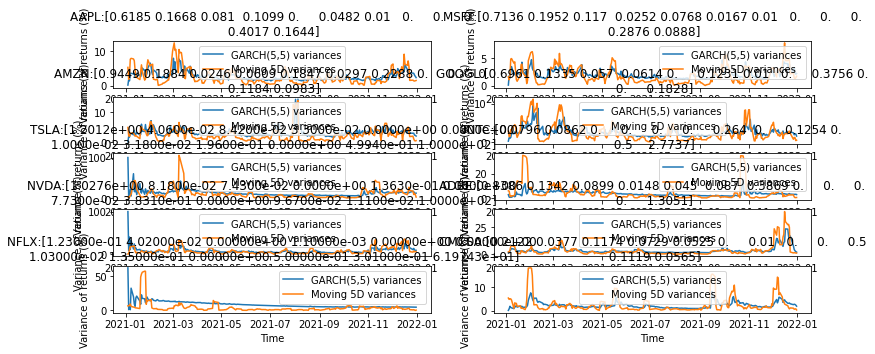

|    | Ticker   |     omega |   alpha_1 |   alpha_2 |    alpha_3 |   alpha_4 |   alpha_5 |    beta_1 |    beta_2 |   beta_3 |    beta_4 |    beta_5 |    sigma0^2 |
|---:|:---------|----------:|----------:|----------:|-----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|------------:|
|  0 | AAPL     | 0.618537  | 0.166817  | 0.0809956 | 0.10987    | 0         | 0.0482073 | 0.01      | 0         | 0        | 0         | 0.401653  |   0.164427  |
|  1 | MSFT     | 0.713589  | 0.195223  | 0.116979  | 0.0251955  | 0.0767737 | 0.0166534 | 0.01      | 0         | 0        | 0         | 0.28759   |   0.0888009 |
|  2 | AMZN     | 0.94485   | 0.188359  | 0.0246109 | 0.0608729  | 0.184741  | 0.0297189 | 0.22884   | 0         | 0        | 0         | 0.118395  |   0.0983411 |
|  3 | GOOGL    | 0.696089  | 0.133488  | 0.0569657 | 0.0613873  | 0         | 0.123134  | 0.01      | 0         | 0.375603 | 0         | 0         |   0.182835  |
|  4 | TSLA     

In [ ]:
for i in range(1,6):  
    #GARCH parameters
    p=i
    q=i
    NASDAQ_parameters=pd.DataFrame(columns=["Ticker","omega"]+[f"alpha_{i}" for i in range(1,p+1)]+[f"beta_{i}" for i in range(1,p+1)]+["sigma0^2"])
    #Sample Theta
    Theta0 = [1]+[1]+[0.0001 for i in range(p-1)]+[1]+[0.0001 for i in range(q-1)]+[1]
    bounds=[(0.01,2)]+[(0.01,1)]+[(0,0.5) for i in range(p-1)]+[(0.01,1)]+[(0,0.5) for i in range(q-1)]+[(0.01,100)]
    pyplot.figure(figsize=(12.5,5))
    for count, key in enumerate(NASDAQ.keys()):
        print(f"Calculating {key}...")
        train_iter = NASDAQ[key][:datetime(year=2020,month=12,day=31)]
        test_iter=NASDAQ[key][datetime(year=2021,month=1,day=1):]
        returns=train_iter['logStopa dzienna']-np.mean(train_iter['logStopa dzienna'])
        grad_f=nll_grad(returns,p,q)
        ThetaOpt = sopt.fmin_l_bfgs_b(
            lambda Theta: gradient_descent(Theta, returns,grad_f,p,q,verbose=False,plots=False),x0=Theta0,bounds=bounds,pgtol=1e-30,maxfun=200,factr=10,epsilon=1e-16)
        sigma2s=compute_general_garch(ThetaOpt[0],test_iter['logStopa dzienna']-np.mean(test_iter['logStopa dzienna']),p=p,q=q)
        pyplot.subplot(5,2,count+1)
        pyplot.plot(test_iter.index,sigma2s,label=f"GARCH({p},{q}) variances")
        if p==1:
            mstd=(test_iter['logStopa dzienna']-np.mean(test_iter['logStopa dzienna']))**2
        else:
            mstd=(returns[-p:].append(test_iter['logStopa dzienna']-np.mean(test_iter['logStopa dzienna'])).rolling(p).std()**2)[p:]
        pyplot.plot(test_iter.index,mstd,label=f"Moving {p}D variances")
        pyplot.title(f"{key}:{np.round(ThetaOpt[0],4)}")
        pyplot.xlabel("Time")
        pyplot.ylabel("Variance of returns (%)")
        pyplot.legend()
        NASDAQ_parameters.loc[len(NASDAQ_parameters)]=([key]+list(ThetaOpt[0]))
    pyplot.tight_layout()
    pyplot.show()
    print(NASDAQ_parameters.to_markdown())


GARCH(p,q) $\sigma^2$-s looks quite similar to the moving 20 days ones. It's because both GARCH and Moving Variance are just functions on previous data and even if f.e. GARCH(1,1) seemingly only takes one previous variance into account it actually takes all of them based on a way a single volatility was created recursively.

So which $p$ and $q$ is the best one for predicting actual variances? If only there was a measure of error between two time series... Well, this whole projects is mainly about finding out something exists (and struggling to implement it) so let us introduce the Symetrical Mean Absolute Percentage Error (**sMAPE**) as follows:
$$\textbf{sMAPE}_{(p,q)}(F_{k \in \lbrace1,\ldots n \rbrace})=\frac{100\%}{n}\Sigma_{k=1}^n \frac{|A_k-F_k|}{(|A_k|+|F_k|)},$$
where:

* $n$-number of days in tested data;
* $A_k$-the actual variance of returns on day $k$;
* $F_k$-GACH(p,q) variance calculated with the actual returns on day $k$.\
The function below calculates GARCH(p,q) parameters on train set and calculates the sMAPE error parameter in compatition to **test**.

*Adjusted_window* as True sets the actual variances as moving variances with window $p$, otherwise the window is always $20$.

In [ ]:
def sMAPE(train,test,p,q,adjusted_window=True):
    returns=train['logStopa dzienna']-np.mean(train['logStopa dzienna'])
    test_returns=test['logStopa dzienna']-np.mean(test['logStopa dzienna'])
    if adjusted_window:
        if p==1:
            real_sigma2s=test_returns**2
        else:
            real_sigma2s=(returns[-p:].append(test_returns).rolling(p).std()**2)[p:]
    else:
        real_sigma2s=(returns[-20:].append(test_returns).rolling(20).std()**2)[20:]
    Theta0 = [1]+[1]+[0.00001 for i in range(p-1)]+[1]+[0.00001 for i in range(q-1)]+[1]
    bounds=[(0.01,2)]+[(0.01,1)]+[(0.00001,0.5) for i in range(p-1)]+[(0.01,1)]+[(0.00001,0.5) for i in range(q-1)]+[(0.01,100)]
    grad_f=nll_grad(returns,p,q)
    ThetaOpt = sopt.fmin_l_bfgs_b(
            lambda Theta: gradient_descent(Theta, returns,grad_f,p,q,verbose=False,plots=False),x0=Theta0,bounds=bounds,pgtol=1e-30,maxfun=200,factr=10,epsilon=1e-16)
    garch_sigma2s=compute_general_garch(ThetaOpt[0],test_returns,p=p,q=q)
    smape=100/len(real_sigma2s)*np.sum(np.abs(real_sigma2s-garch_sigma2s)/(np.abs(real_sigma2s)+np.abs(garch_sigma2s)))
    return smape,ThetaOpt[0]

Let us come back to our sample train and test. We're gonna calculate its sMAPE for different GARCH-s. First let the window of the moving variance (as the actual one) be adjusted to $p$.

In [ ]:
for i in range(1,6): 
    result=sMAPE(sample_train,sample_test,p=i,q=i)
    print(f"GARCH({i},{i}) sMAPE on sample train and test:{round(result[0],2)}% with Theta={result[1]}")

GARCH(1,1) sMAPE on sample train and test:59.45% with Theta=[0.0482595  0.07205488 0.90576521 0.41232914]
GARCH(2,2) sMAPE on sample train and test:56.49% with Theta=[0.0702355  0.04246026 0.06187406 0.56412068 0.29950231 0.54115498]
GARCH(3,3) sMAPE on sample train and test:45.15% with Theta=[7.25398538e-02 4.44611618e-02 6.45579961e-02 1.00000000e-05
 6.69953178e-01 1.00000000e-05 1.87952744e-01 5.08073454e-01]
GARCH(4,4) sMAPE on sample train and test:39.33% with Theta=[1.43094863e-01 3.43138917e-02 1.08491307e-01 4.83027510e-02
 2.50156574e-02 2.29198536e-01 1.00000000e-05 1.00000000e-05
 4.89999368e-01 1.15934011e+00]
GARCH(5,5) sMAPE on sample train and test:35.65% with Theta=[2.12160797e-01 3.77071555e-02 1.17421358e-01 7.28596398e-02
 5.24642218e-02 1.00000000e-05 1.00000000e-02 1.00000000e-05
 1.00000000e-05 5.00000000e-01 1.11895968e-01 5.65177998e-02]


It is clear that if the moving variance is calculated with bigger window, the achieved values are much more stable, that's probably why sMAPE decreased significantly every time we increased $p$ in GARCH. This means that it will be fair to compare every GARCH to Moving Variances with constant window of 20 days.

In [ ]:
for i in range(1,6): 
    result=sMAPE(sample_train,sample_test,p=i,q=i,adjusted_window=False)
    print(f"GARCH({i},{i}) sMAPE on sample train and test:{round(result[0],2)}% with Theta={result[1]}")

GARCH(1,1) sMAPE on sample train and test:15.94% with Theta=[0.0482595  0.07205488 0.90576521 0.41232914]
GARCH(2,2) sMAPE on sample train and test:15.74% with Theta=[0.0702355  0.04246026 0.06187406 0.56412068 0.29950231 0.54115498]
GARCH(3,3) sMAPE on sample train and test:15.96% with Theta=[7.25398538e-02 4.44611618e-02 6.45579961e-02 1.00000000e-05
 6.69953178e-01 1.00000000e-05 1.87952744e-01 5.08073454e-01]
GARCH(4,4) sMAPE on sample train and test:16.49% with Theta=[1.43094863e-01 3.43138917e-02 1.08491307e-01 4.83027510e-02
 2.50156574e-02 2.29198536e-01 1.00000000e-05 1.00000000e-05
 4.89999368e-01 1.15934011e+00]
GARCH(5,5) sMAPE on sample train and test:17.39% with Theta=[2.12160797e-01 3.77071555e-02 1.17421358e-01 7.28596398e-02
 5.24642218e-02 1.00000000e-05 1.00000000e-02 1.00000000e-05
 1.00000000e-05 5.00000000e-01 1.11895968e-01 5.65177998e-02]


The results are quite similar, GARCH(2,2) turned out to be the one with the smallest sMAPE in this particular scenario.
But to properly validate the best $p$ and $q$ we need to go through more scenarios. Let us split the whole training data (2011-2020) into 10 sets and create the following 9 train/test scenarios for establishing parameters/calculating sMAPES:
* Train: [1] Test: [2]
* Train: [1,2] Test: [3]\
...
* Train: [1,2,3,...9] Test: [10]

For each scenario with each variant of $p$ and $q$ we will provide the value of sMAPE and pick pair (p,q) with the smallest one. This is going to give a point to this pair and after looking at all scenarios we will get a dictionary of scores for each GARCH(p,q) version. It is important to mention that we've only use pairs where $p=q=i$ for $i=1,\ldots5$ because of computations time issues. Nonetheless that will gives us the idea of which GARCH(p,q) works the most for providing the next volatility based on previous data.

In [ ]:
def find_best_GARCH(data):
  tscv = TimeSeriesSplit(n_splits=9)
  best_GARCH = {1:0,2:0,3:0,4:0,5:0}
  count=1
  for train_index, test_index in tscv.split(data):
    print(f"Split: {count}")
    count+=1
    X_train, X_test = data.iloc[train_index], data.iloc[test_index]
    smapes= []
    for key in best_GARCH:
        smape=sMAPE(X_train,X_test,p=key,q=key,adjusted_window=False)[0]
        smapes+=[smape]
        print(f'sMAPE of GARCH({key},{key}):{round(smape,2)}%')
    x=np.argmin(np.asarray(smapes))
    best_GARCH[x+1]+=1
  return best_GARCH

Obviously doing it only for one company is not enough. Now the scores will sum up throught all of the 10 companies data (takes hours to load so don't click it and just enjoy the already provided results).

In [ ]:
GARCHs_scores={i:0 for i in range(1,6)}
for key in NASDAQ:
    print(f'Currently at {key}...')
    train=NASDAQ[key][:datetime(year=2020,month=12,day=31)]
    scores=find_best_GARCH(train)
    for key,value in scores.items():
        GARCHs_scores[key]+=value
    print(f'Top p,q after that round:{max(GARCHs_scores,key=GARCHs_scores.get)}')
print(GARCHs_scores)

NameError: ignored

Now it is clear that out of all checked GARCH(p,q) models the one with $p=q=5$ did the best by far in forecasting the actual variances. Keeping that in mind we can now switch to the main goal of this project which is (besides passing ML course) using GARCH in the Bollinger band.
# Bollinger band


---
The Bollinger band is a strategy where the trader buys/sells when the stock price hits the previously established lower/upper band. Here are the formulas for the standard Bollinger bands:
$$\text{upper band}=\text{moving average}_{20D}(S)+2\cdot\text{moving std}_{20D}(S)$$
$$\text{lower band}=\text{moving average}_{20D}(S)-2\cdot\text{moving std}_{20D}(S)$$
What we want to do is to change the moving standard deviations into GARCH ones and see if it will resolve in better earnings than the basic strategy.

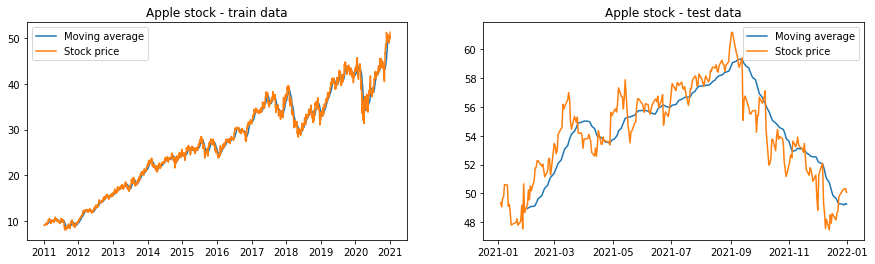

In [ ]:
#BANDA BOLLINGERA
#zwykła moving average

def moving_average(data, n):
  ma = data.rolling(n).mean()
  return ma

ma_apl = moving_average(sample_train['Zamkniecie'], 20)
ma_apltest = moving_average(sample_test['Zamkniecie'], 20)
pyplot.figure(figsize=(15, 4))
pyplot.subplot(1, 2, 1)
pyplot.plot(ma_apl, label = "Moving average")
pyplot.plot(sample_train['Zamkniecie'], label = "Stock price")
pyplot.title("Apple stock - train data")
pyplot.legend()
pyplot.subplot(1,2,2)
pyplot.plot(ma_apltest, label = "Moving average")
pyplot.plot(sample_test['Zamkniecie'], label = "Stock price")
pyplot.title("Apple stock - test data")
pyplot.legend()
pyplot.show()

Besides using GARCH instead of standard moving volatilities we're gonna change the moving average into the Kalman's filter (with built-in function as it's not the main topic of this project) which takes out the white noice of the data and therefore seems to be a better indicator of prices trends.
Since our GARCH variances are ones of returns and we want prices volatilities we need to rescale them as follows:
$$\text{Var}(S_t)=S_{t-1}\cdot \sigma^2_t$$
where $\sigma^2_t$ is our GARCH returns variance at day $t$.

In [ ]:
#funkcja licząca tą bandę, można używać garchowych sigm(trzeba podać parametry ThetaOpt) albo zwykłego sd z oknem n
#jako data podajemy wektor cen zamknięcia
#tutaj jest jakiś błąd rozumowania
p=5
q=5
def Bollinger_bands_garch(data, n, ThetaOpt, garch = True,p=1,q=1,K=2):
  returns = np.array(np.log(np.asarray(data[n:])/np.asarray(data[(n-1):(-1)])))*100
  historical=np.concatenate((np.zeros(1),np.array(np.log(np.asarray(data[1:n])/np.asarray(data[:(n-1)])))))*100
  if garch:
    kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = data.values[n-1],
                  initial_state_covariance = 1,
                  observation_covariance = 1,
                  transition_covariance = 0.01)
    ma, cov =kf.filter(data.values)
    ma, std = ma.squeeze(), np.std(cov.squeeze())
    #sigma_2 = compute_garch(ThetaOpt[0],ThetaOpt[1],ThetaOpt[2],returns,ThetaOpt[3])
    sigma_2 = compute_general_garch(ThetaOpt,returns,p=p,q=q,forecast=True,historical=historical)/(100**2)
    sd = np.sqrt(sigma_2)
    sd=sd*data[(n-1):-1]
  else:
    ma = moving_average(data,n)
    sd = data.rolling(n).std()[n:]
    #print(np.max(sd),np.min(sd),np.mean(sd))
  upper = ma[n:] + K*sd
  lower = ma[n:] - K*sd
  return upper, lower

returns=sample_train['logStopa dzienna']-np.mean(sample_train['logStopa dzienna'])
#Sample Theta
Theta0 = [1]+[1]+[0.001 for i in range(p-1)]+[1]+[0.001 for i in range(q-1)]+[1]
#set timer
t0=time()
#Grad function for our returns (depending on current Theta)
grad_f=nll_grad(returns,p,q)
bounds=[(0.01,2)]+[(0.01,1)]+[(0.001,0.4) for i in range(p-1)]+[(0.01,1)]+[(0.001,0.4) for i in range(q-1)]+[(0.01,2)]
ThetaOpt = sopt.fmin_l_bfgs_b(
    lambda Theta: gradient_descent(Theta, returns,grad_f,p,q,verbose=False,plots=False),x0=Theta0,bounds=bounds,pgtol=1e-30,maxfun=200,factr=10,epsilon=1e-16)

n=20#okno
up_g, low_g = Bollinger_bands_garch(data=sample_train['Zamkniecie'], n=n,ThetaOpt=ThetaOpt[0], garch=True, p=p,q=q,K=2)
up, low = Bollinger_bands_garch(sample_train['Zamkniecie'], n,ThetaOpt[0], garch = False,K=2)

Here are some plots of standard Bollinger band and our variation on sample Comcast train and test data.

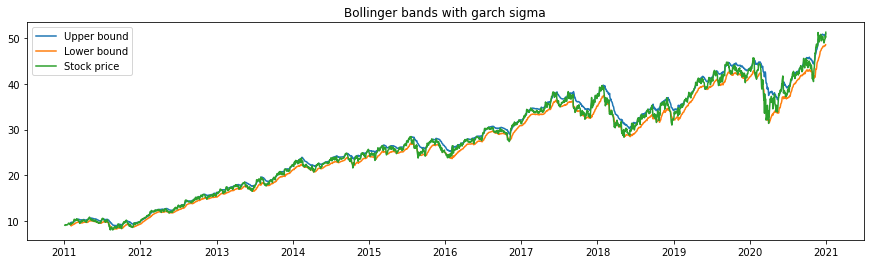

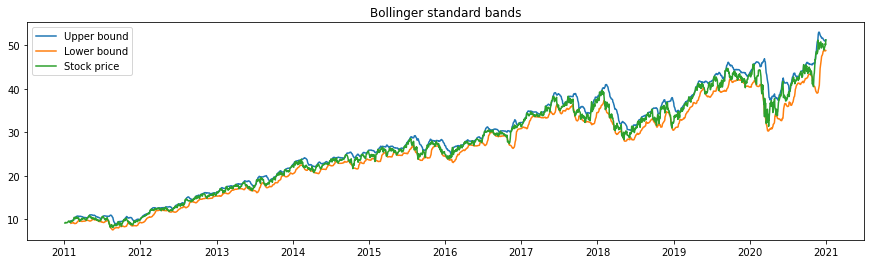

In [ ]:
#wykresy band na train plus trajektoria
pyplot.figure(figsize=(15, 4))
pyplot.plot(up_g, label = "Upper bound")
pyplot.plot(low_g, label = "Lower bound")
pyplot.plot(sample_train['Zamkniecie'], label = "Stock price")
pyplot.title("Bollinger bands with garch sigma")
pyplot.legend()
pyplot.show()

pyplot.figure(figsize=(15, 4))
pyplot.plot(up, label = "Upper bound")
pyplot.plot(low, label = "Lower bound")
pyplot.plot(sample_train['Zamkniecie'], label = "Stock price")
pyplot.title("Bollinger standard bands")
pyplot.legend()
pyplot.show()

Below we can see bands calculated for test set for one dataset using fitted on train set garch optimal parameters and standard rolling window sigmas. 

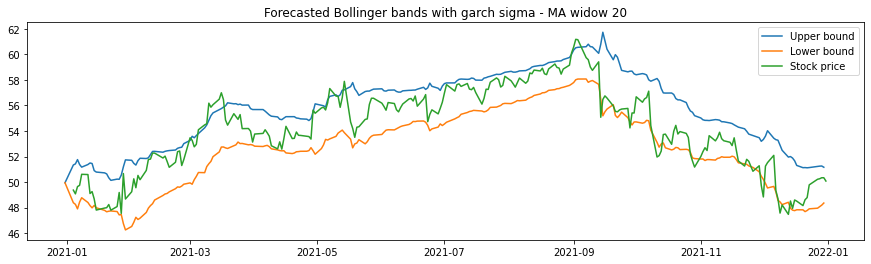

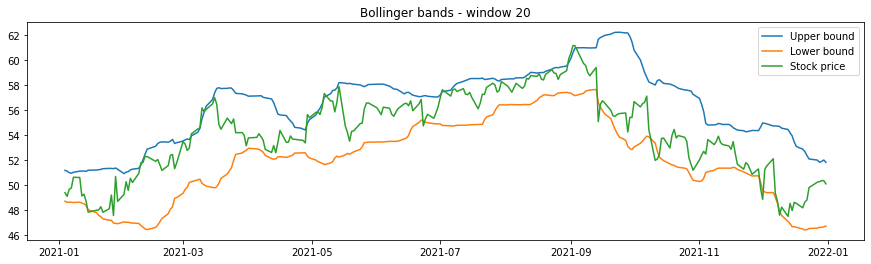

In [ ]:
#wykresy na test 
test_up_g, test_low_g = Bollinger_bands_garch(data=sample_train['Zamkniecie'][-n:].append(sample_test['Zamkniecie']),n=n,ThetaOpt=ThetaOpt[0],garch=True,p=p,q=q,K=2)
up, low = Bollinger_bands_garch(data=sample_train['Zamkniecie'][-n:].append(sample_test['Zamkniecie']),n=n,ThetaOpt=ThetaOpt[0], garch = False,K=2)

pyplot.figure(figsize=(15, 4))
pyplot.plot(test_up_g, label = "Upper bound")
pyplot.plot(test_low_g, label = "Lower bound")
pyplot.plot(sample_test['Zamkniecie'], label = "Stock price")
pyplot.title(f"Forecasted Bollinger bands with garch sigma - MA widow {n}")
pyplot.legend()
pyplot.show()

pyplot.figure(figsize=(15, 4))
pyplot.plot(up, label = "Upper bound")
pyplot.plot(low, label = "Lower bound")
pyplot.plot(sample_test['Zamkniecie'], label = "Stock price")
pyplot.title(f"Bollinger bands - window {n}")
pyplot.legend()
pyplot.show()

As we said earlier Bollinger band is a strategy we can use to profit from stock price changes. Here's our *strategy()* function taking already established Bollinger bands and using them to make profit out of selling and buying one unit of an asset. When *short* is set as False, there is no shorting on the market so we cannot sell something that we don't have. In both strategies we can have at most one unit of asset, and if shorting allowed minimum minus one. 

In first strategy we allow 'doubled' transaction - meaning we can buy or sell two assets at once (changing position from short to long and the opposite). It is only different from second strategy (one day - max one transaction) when shorting is allowed.

Bought 1 asset at price 49.37253952026367, current balance: -49.37253952026367
Sold 1 asset at price 50.66871643066406, current balance 1.2961769104003906
Bought 1 asset at price 52.597625732421875, current balance: -51.301448822021484
Sold 1 asset at price 55.635902404785156, current balance 4.334453582763672
Bought 1 asset at price 55.072547912597656, current balance: -50.738094329833984


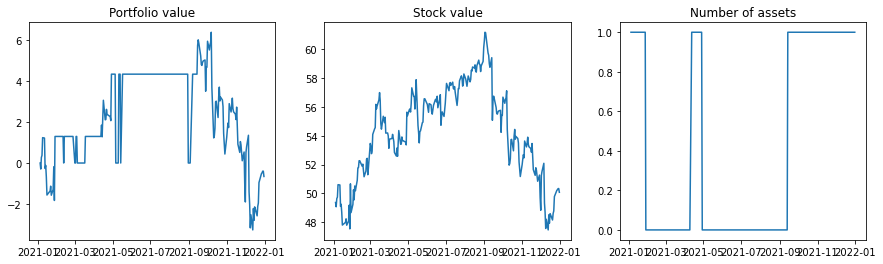

(-0.6560745239257812, -50.738094329833984, 1)
Bought 1 asset at price 47.81123352050781, current balance: -47.81123352050781
Sold 1 asset at price 51.76850509643555, current balance 3.9572715759277344
Bought 1 asset at price 54.728363037109375, current balance: -50.77109146118164
Sold 1 asset at price 57.62853240966797, current balance 6.857440948486328
Bought 1 asset at price 55.072547912597656, current balance: -48.21510696411133


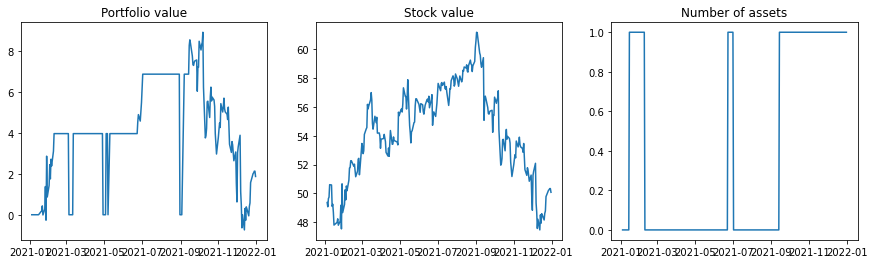

(1.866912841796875, -48.21510696411133, 1)
Bought one asset at price 49.37253952026367, current balance: -49.37253952026367
Sold one asset at price 50.66871643066406, current balance 1.2961769104003906
Sold one asset at price 52.2692985534668, current balance 53.56547546386719
Bought one asset at price 52.597625732421875, current balance: 0.9678497314453125
Sold one asset at price 55.635902404785156, current balance 56.60375213623047
Bought one asset at price 55.072547912597656, current balance: 1.5312042236328125
Bought one asset at price 56.469425201416016, current balance: -54.9382209777832


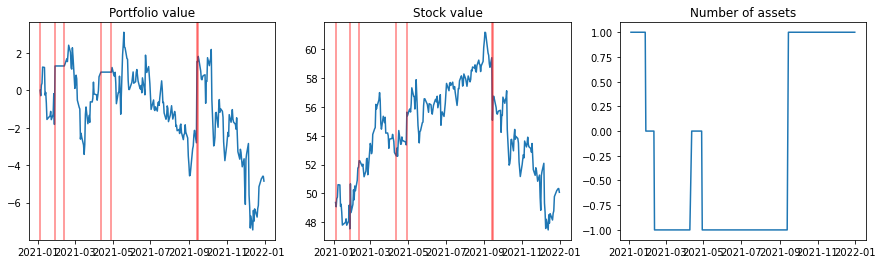

(-4.856201171875, -54.9382209777832, 1)
Bought one asset at price 47.81123352050781, current balance: -47.81123352050781
Sold one asset at price 51.76850509643555, current balance 3.9572715759277344
Sold one asset at price 54.095733642578125, current balance 58.05300521850586
Bought one asset at price 54.728363037109375, current balance: 3.3246421813964844
Sold one asset at price 57.62853240966797, current balance 60.95317459106445
Bought one asset at price 55.072547912597656, current balance: 5.880626678466797
Bought one asset at price 51.96270751953125, current balance: -46.08208084106445


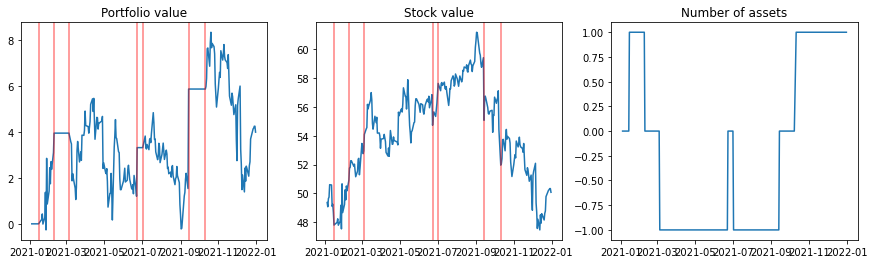

(3.99993896484375, -46.08208084106445, 1)


In [ ]:

#'double transactions'
def strategy(upper, lower, real, verbose = True,short = True, plot = False):
  n = len(real)
  balance = 0
  asset = 0
  final_balance = 0
  portfolio_value = np.zeros(n)
  transaction = np.zeros(n)
  for i in range(n):
    if real[i] >= upper[i] and asset != -1:   #sprzedajemy
      if not short and asset == 0:
        #asset = 0
        continue
      elif not short and asset == 1:
        asset = 0
      balance += (asset + 1) * real[i]
      if verbose:
        print(f'Sold {asset + 1} asset at price {real[i]}, current balance {balance}')
      asset = -1
      if not short:
        asset = 0
    if real[i] <= lower[i] and asset != 1:
      balance -= (-asset + 1)*real[i]
      if verbose:
         print(f'Bought {-asset + 1} asset at price {real[i]}, current balance: {balance}')
      asset = 1  
    transaction[i] = asset
    portfolio_value[i] = balance + asset*real[i]
  final_balance = portfolio_value[n-1]
  if plot:
    pyplot.figure(figsize=(15, 4))
    pyplot.subplot(1, 3, 1)
    pyplot.plot(real.index,portfolio_value, label = "Portfolio value")
    pyplot.title("Portfolio value")
    pyplot.subplot(1, 3, 2)
    pyplot.plot(real, label = "Stock price")
    pyplot.title("Stock value")
    pyplot.subplot(1, 3, 3)
    pyplot.plot(real.index, transaction, label = "Transactions")
    pyplot.title("Number of assets")
    pyplot.show()
  return final_balance, balance, asset

#'single transactions' 
def strategy2(upper, lower, real, verbose = True, short = True, plot = False):
  n = len(real)
  balance = 0
  asset = 0
  portfolio_value = np.zeros(n)
  transaction = np.zeros(n)
  transaction2 = np.zeros(n)
  for i in range(n):
    if real[i] >= upper[i] and asset != -1:   #sprzedajemy
      if not short and asset == 0:
        continue
      balance += real[i]
      if verbose:
        print(f'Sold one asset at price {real[i]}, current balance {balance}')
      asset -= 1
      transaction2[i] = -1
    if real[i] <= lower[i] and asset != 1:
      balance -= real[i]
      if verbose:
         print(f'Bought one asset at price {real[i]}, current balance: {balance}')
      asset += 1  
      transaction2[i] =1
    transaction[i] = asset
    portfolio_value[i] = balance + asset*real[i]
  final_balance = portfolio_value[n-1]
  if plot:
    xcoords = np.nonzero(transaction2)[0]
    pyplot.figure(figsize=(15, 4))
    pyplot.subplot(1, 3, 1)
    pyplot.plot(real.index,portfolio_value, label = "Portfolio value")
    for xc in xcoords:
      pyplot.axvline(x=real.index[xc], color = 'red', alpha = 0.5)
    pyplot.title("Portfolio value")
    pyplot.subplot(1, 3, 2)
    pyplot.plot(real, label = "Stock price")
    for xc in xcoords:
      pyplot.axvline(x=real.index[xc], color = 'red', alpha = 0.5)
    pyplot.title("Stock value")
    pyplot.subplot(1, 3, 3)
    pyplot.plot(real.index, transaction, label = "Transactions")
    pyplot.title("Number of assets")
    pyplot.show()
  return final_balance, balance, asset

print(strategy(test_up_g, test_low_g, sample_test['Zamkniecie'],short = False, plot= True))
print(strategy(up, low, sample_test['Zamkniecie'],short = False, plot= True))

print(strategy2(test_up_g, test_low_g, sample_test['Zamkniecie'],  plot= True))
print(strategy2(up, low, sample_test['Zamkniecie'],short = True, plot= True))

Standard Bollinger band was made with $K=2$ as the added/subtracted standard deviation multiplier. But in our variation we can set the best $K$ out of many options to see how earnings from such bands compare to standard Bollinger ones\
The idea is very similar to validation of GARCH-s $p$ and $q$, we split the data and this time calculate the earnings from our bands with various multipliers to pick the most profitable one. The main difference is that we do it uniquely for given train data so for example if you're about to trade Apple in 2021, the Bollinger band is calculated on previous years and $K$ is set as the best one on those training years. The benchmark for our results are earnings from standard Bollinger with $K=2$ in given Split.

In [ ]:
#chcemy dobrać takie K żeby nam zarabiała ta strategia
#będziemy sprawdzać K z przedziału [2,10] dla którego dostaniemy najlepszy zwrot
#będziemy sobie trenować parametry na dwóch latach i sprawdzać na kolejnym 
from sklearn.model_selection import TimeSeriesSplit

def find_best_K(data, n_window= 20, strat = strategy,p=p,q=q, short = True, verbose = True):
  tscv = TimeSeriesSplit(n_splits=9)
  n = 1
  best_K = {}
  for train_index, test_index in tscv.split(data):
    if verbose:
      print(f"Split: {n}")
    best_K[n] = 0
    X_train, X_test = data.iloc[train_index], data.iloc[test_index]
    ret= X_train['logStopa dzienna']
    #Sample Theta
    Theta0 = [1]+[1]+[0.00001 for i in range(p-1)]+[1]+[0.00001 for i in range(q-1)]+[1]
    bounds=[(0.01,2)]+[(0.01,1)]+[(0.00001,0.5) for i in range(p-1)]+[(0.01,1)]+[(0.00001,0.5) for i in range(q-1)]+[(0.01,100)]
    grad_f=nll_grad(ret,p,q)
    ThetaOpt0 = sopt.fmin_l_bfgs_b(
            lambda Theta: gradient_descent(Theta, ret,grad_f,p,q,verbose=False,plots=False),x0=Theta0,bounds=bounds,pgtol=1e-30,maxfun=200,factr=10,epsilon=1e-16)
    diff = {}      
    up, low = Bollinger_bands_garch(X_train['Zamkniecie'][-n_window:].append(X_test['Zamkniecie']), n_window,ThetaOpt0[0], garch = False,K=2)
    payoff_standard = strategy(up, low, X_test['Zamkniecie'], verbose = False, short = short)[0]
    for K in range(2,10):
      up_g, low_g = Bollinger_bands_garch(X_train['Zamkniecie'][-n_window:].append(X_test['Zamkniecie']), n_window,ThetaOpt0[0], garch=True, p=p,q=q,K=K)
      payoff_garch = strategy(up_g, low_g, X_test['Zamkniecie'], verbose = False, short = short)[0]
      if verbose:
        print(f"K = {K}, payoff from GARCH strategy: {payoff_garch}, payoff from standard Bollinger: {payoff_standard}")
      diff[K] = payoff_garch - payoff_standard
      #if diff[K] > 0:
      #  best_K[n] = K
      #  break
    #if best_K[n] == 0:
    best_K[n] = max(diff, key=diff.get)
    if verbose:
      print(f"Best K for current split: {best_K[n]}")
    n +=1
  values_list = list(best_K.values())
  K = max(set(values_list), key=values_list.count)
  #K= np.floor(np.mean(values_list))
  return K

find_best_K(sample_train, strat = strategy2, short = True)
#ze niby 3


As we can see $K=3$ turned out to be the best one when it comes to earnings on our GARCH(5,5) model based only on COMCAST data. Obviously as we established earlier, it will optimize in the similar way every time based on the given train set for the Bollinger band.

Chosen K: 3
Optimal parameters: [9.91644618e-01 2.94626924e-01 1.00000000e-05 1.00000000e-05
 1.00000000e-05 7.50204497e-02 1.00000000e-02 7.93327371e-02
 1.00000000e-05 1.48912537e-01 1.00000000e-05 1.97125331e+01]


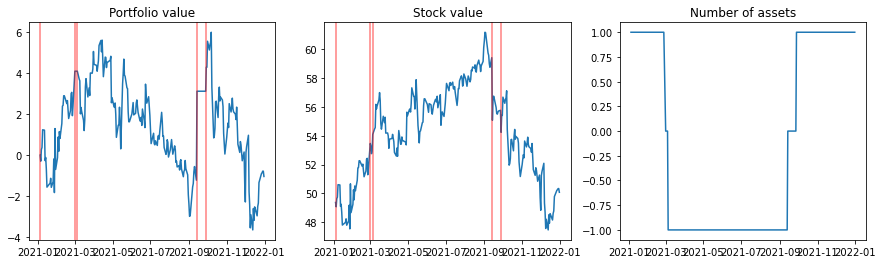

Final balance from GARCH strategy: -1.0404167175292969


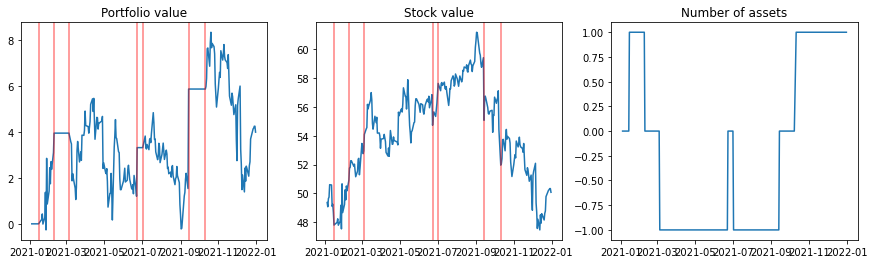

Final balance from standard strategy: 3.99993896484375


(3, -1.0404167175292969, 3.99993896484375)

In [ ]:
KOpt=3
### Bollinger ostateczny 
def use_Bollinger(p,q,strategy, train_data, test_data, short = True, plot = True, verbose = False,K=0):
  if K == 0:
    K = find_best_K(train_data, strat = strategy, p = p, q = q, short = short, verbose = False)
    
  print(f"Chosen K: {K}")

  #find optimal theta for test 
  ret= (test_data['logStopa dzienna'])
  Theta0 = [1]+[1]+[0.00001 for i in range(p-1)]+[1]+[0.00001 for i in range(q-1)]+[1]
  bounds=[(0.01,2)]+[(0.01,1)]+[(0.00001,0.5) for i in range(p-1)]+[(0.01,1)]+[(0.00001,0.5) for i in range(q-1)]+[(0.01,100)]
  grad_f=nll_grad(ret,p,q)
  ThetaOpt0 = sopt.fmin_l_bfgs_b(
            lambda Theta: gradient_descent(Theta, ret,grad_f,p,q,verbose=False,plots=False),x0=Theta0,bounds=bounds,pgtol=1e-30,maxfun=200,factr=10,epsilon=1e-16)
    
  
  print(f"Optimal parameters: {ThetaOpt0[0]}")

  #construct bands with chosen K 
  test_up_g, test_low_g = Bollinger_bands_garch(data=train_data['Zamkniecie'][-n:].append(test_data['Zamkniecie']),n=n,ThetaOpt=ThetaOpt0[0],garch=True,p=p,q=q,K=K)
  up, low = Bollinger_bands_garch(data=train_data['Zamkniecie'][-n:].append(test_data['Zamkniecie']),n=n,ThetaOpt=ThetaOpt0[0], garch = False,K=2)

  #appply strategy
  fbg, bg, ag = strategy(test_up_g, test_low_g, test_data['Zamkniecie'], short = short, plot= plot, verbose = verbose)
  print(f"Final balance from GARCH strategy: {fbg}")
  fb, b, a = strategy(up, low, test_data['Zamkniecie'],short = short, plot= plot, verbose = verbose)
  print(f"Final balance from standard strategy: {fb}")
  return K, fbg, fb

use_Bollinger(p,q,strategy2, train_data=sample_train, test_data = sample_test, short = True, verbose = False,K=KOpt)

Here are some extra tables of our Bollinger band variation results (for all companies) with comparition to standard one on a market with and without shorting.

In [ ]:
def Bollinger_tables(strategy, short,plots = False, K0 = 0):
  Bollinger_values = pd.DataFrame(columns=["Ticker","chosen K", "GARCH balance", "Standard balance", "Difference", "Winner"])
  w = 0
  print(strategy.__name__)
  if short:
    print("Shorting allowed")
  else:
    print("Shorting not allowed")
  if K0 ==0:
    print("With K optimization")
  else:
    print(f"K={K0}")
  for count, key in enumerate(NASDAQ.keys()):
    train_iter = NASDAQ[key][:datetime(year=2020,month=12,day=31)]
    test_iter = NASDAQ[key][datetime(year=2021,month=1,day=1):]
    K, fbg, fb = use_Bollinger(p,q,strategy= strategy, train_data=train_iter, test_data = test_iter, short = short, plot=plots, verbose = False, K = K0)
    if fbg > fb:
      win = 'GARCH'
      w +=1
    else:
      win = "Standard"
    Bollinger_values.loc[len(Bollinger_values)]=([key]+[K]+[fbg]+[fb]+ [fbg-fb] + [win])
  print(Bollinger_values.to_markdown()) 
  print(f'GARCH better {w} times, total difference: {np.sum(Bollinger_values["Difference"])}')

Bollinger_tables(strategy2, short = True, K0=2)
Bollinger_tables(strategy2, short = True, K0=0)
Bollinger_tables(strategy2, short = False, K0 = 2)
Bollinger_tables(strategy2, short = False, K0=0)


strategy2
Shorting allowed
K=2
Chosen K: 2
Optimal parameters: [4.70765693e-01 1.00000000e-02 2.95596130e-02 1.00000000e-05
 1.00000000e-05 1.34226893e-01 6.19934919e-01 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.35014620e+01]
Final balance from GARCH strategy: -10.738677978515625
Final balance from standard strategy: -15.5689697265625
Chosen K: 2
Optimal parameters: [1.35801954e-01 1.00000000e-02 4.03317245e-02 1.00000000e-05
 3.29870717e-02 1.00000000e-05 1.00000000e-02 1.94756761e-01
 4.96010849e-01 1.00000000e-05 1.28105849e-01 1.11715398e+01]
Final balance from GARCH strategy: 24.025146484375
Final balance from standard strategy: 35.54034423828125
Chosen K: 2
Optimal parameters: [3.09466414e-01 1.00000000e-02 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 2.05692035e-02 4.92999008e-01
 1.00000000e-05 1.00000000e-05 3.36783096e-01 1.10325176e+01]
Final balance from GARCH strategy: 1351.300048828125
Final balance from standard strategy: 1235.4499511

In [ ]:
Bollinger_tables(strategy, short = True, K0=2)
Bollinger_tables(strategy, short = True,K0=0)
Bollinger_tables(strategy, short = False, K0 = 2)
Bollinger_tables(strategy, short = False,K0=0)

strategy
Shorting allowed
K=2
Chosen K: 2
Optimal parameters: [4.70765693e-01 1.00000000e-02 2.95596130e-02 1.00000000e-05
 1.00000000e-05 1.34226893e-01 6.19934919e-01 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.35014620e+01]
Final balance from GARCH strategy: -22.6483154296875
Final balance from standard strategy: -18.246627807617188
Chosen K: 2
Optimal parameters: [1.35801954e-01 1.00000000e-02 4.03317245e-02 1.00000000e-05
 3.29870717e-02 1.00000000e-05 1.00000000e-02 1.94756761e-01
 4.96010849e-01 1.00000000e-05 1.28105849e-01 1.11715398e+01]
Final balance from GARCH strategy: 40.219390869140625
Final balance from standard strategy: 24.859146118164062
Chosen K: 2
Optimal parameters: [3.09466414e-01 1.00000000e-02 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 2.05692035e-02 4.92999008e-01
 1.00000000e-05 1.00000000e-05 3.36783096e-01 1.10325176e+01]
Final balance from GARCH strategy: 957.409423828125
Final balance from standard strategy: 1063.63964

Chosen K: 2
Optimal parameters: [4.70765693e-01 1.00000000e-02 2.95596130e-02 1.00000000e-05
 1.00000000e-05 1.34226893e-01 6.19934919e-01 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 1.35014620e+01]


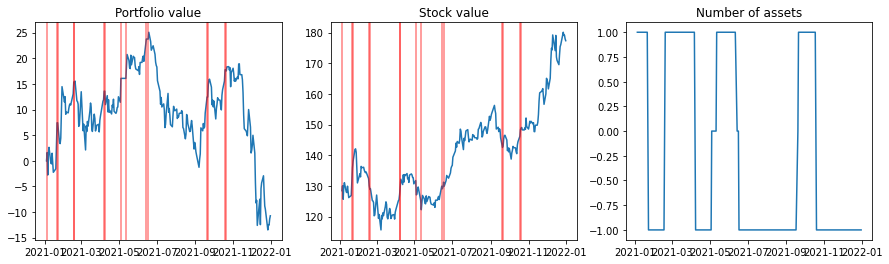

Final balance from GARCH strategy: -10.738677978515625


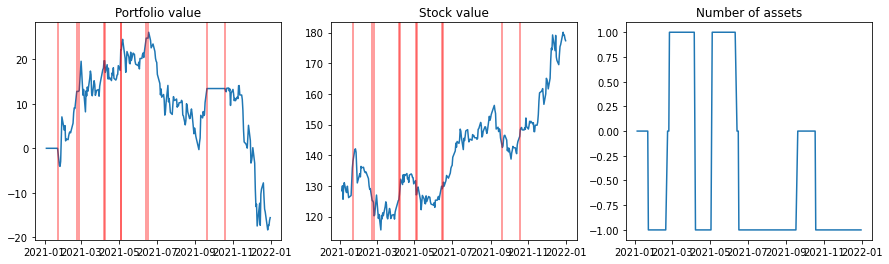

Final balance from standard strategy: -15.5689697265625
Chosen K: 2
Optimal parameters: [1.35801954e-01 1.00000000e-02 4.03317245e-02 1.00000000e-05
 3.29870717e-02 1.00000000e-05 1.00000000e-02 1.94756761e-01
 4.96010849e-01 1.00000000e-05 1.28105849e-01 1.11715398e+01]


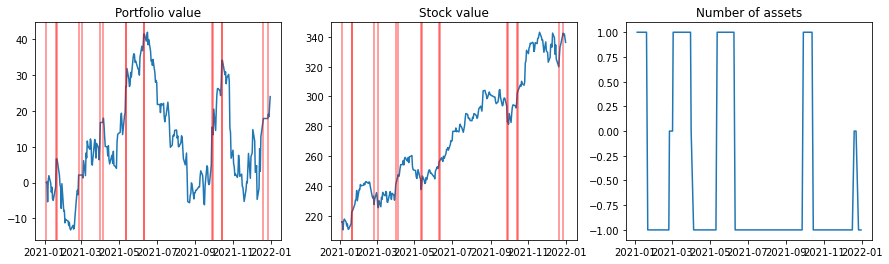

Final balance from GARCH strategy: 24.025146484375


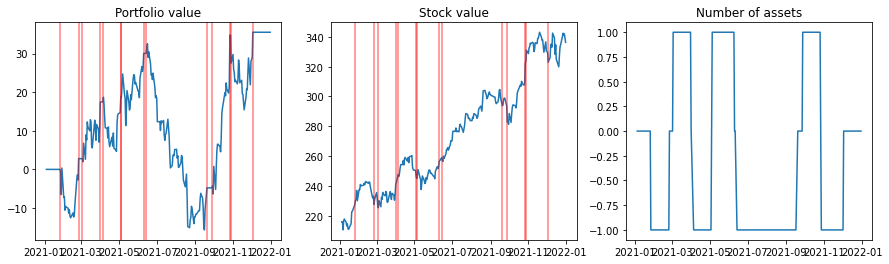

Final balance from standard strategy: 35.54034423828125
Chosen K: 2
Optimal parameters: [3.09466414e-01 1.00000000e-02 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 2.05692035e-02 4.92999008e-01
 1.00000000e-05 1.00000000e-05 3.36783096e-01 1.10325176e+01]


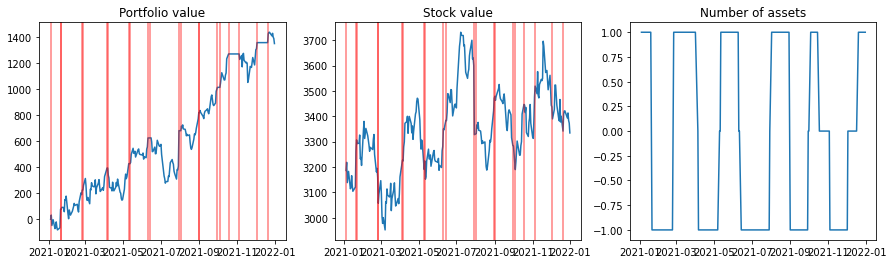

Final balance from GARCH strategy: 1351.300048828125


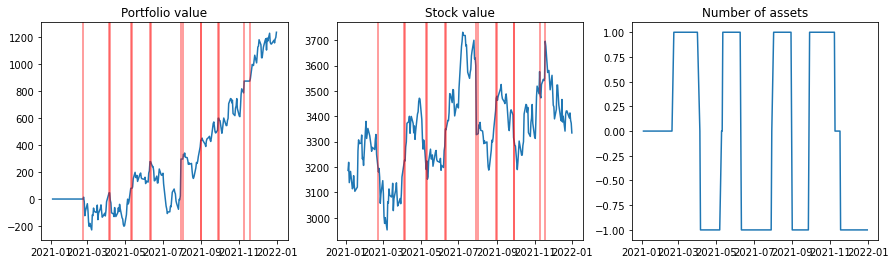

Final balance from standard strategy: 1235.449951171875
Chosen K: 4
Optimal parameters: [1.37077593e+00 9.51546242e-02 6.70368017e-02 1.33137783e-01
 1.00000000e-05 1.15506606e-01 1.00000000e-02 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 2.30324927e+00]


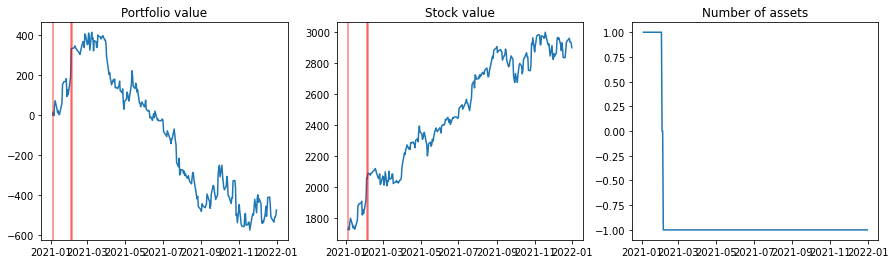

Final balance from GARCH strategy: -475.4600830078125


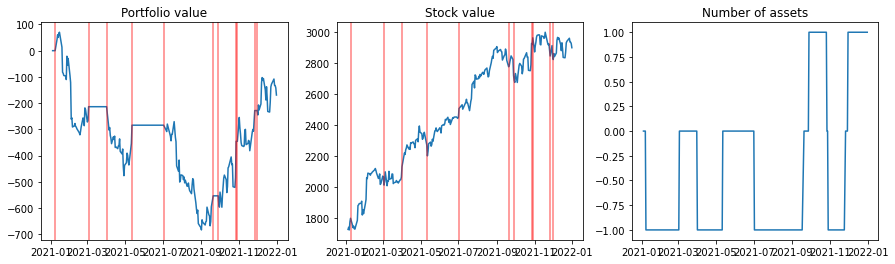

Final balance from standard strategy: -169.18994140625
Chosen K: 3
Optimal parameters: [2.00000000e+00 3.26745595e-01 1.00000000e-05 1.00000000e-05
 1.00000000e-05 5.55100940e-02 2.32212545e-01 1.00000000e-05
 1.00000000e-05 1.00000000e-05 2.53771009e-01 1.19961216e+01]


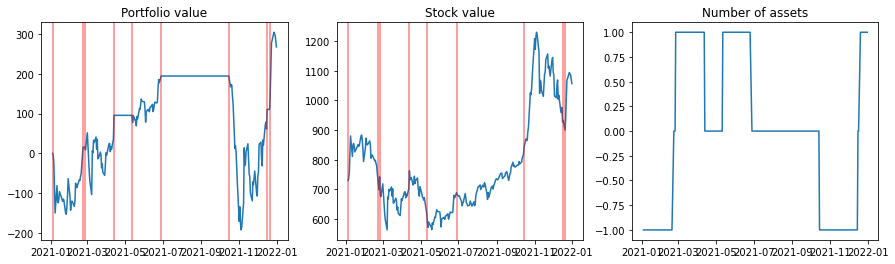

Final balance from GARCH strategy: 267.15008544921875


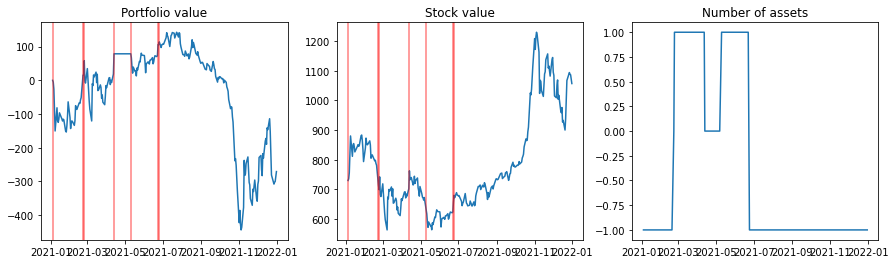

Final balance from standard strategy: -270.67999267578125
Chosen K: 4
Optimal parameters: [1.00956688e+00 1.95277955e-01 1.00000000e-05 1.00000000e-05
 1.00000000e-05 3.40394670e-01 3.25023348e-01 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 9.76707298e-02]


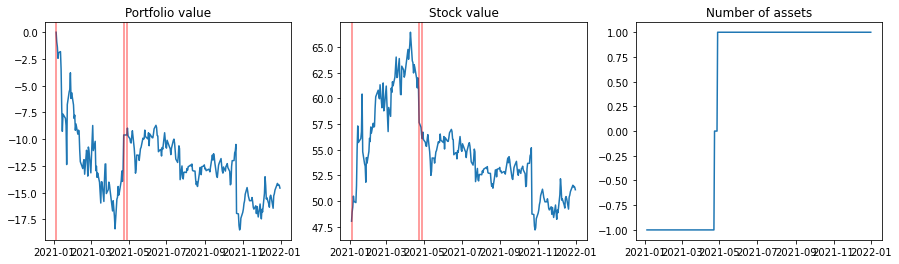

Final balance from GARCH strategy: -14.572216033935547


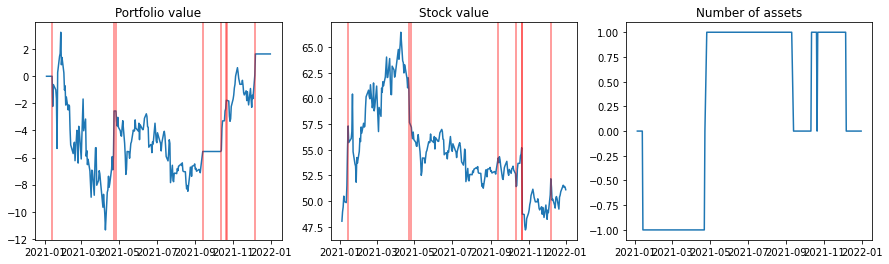

Final balance from standard strategy: 1.6476631164550781
Chosen K: 4
Optimal parameters: [1.90293392e+00 1.00000000e-02 1.00000000e-05 1.00000000e-05
 2.21240143e-01 1.00000000e-05 1.00000000e-02 9.54447373e-02
 4.21488346e-01 1.00000000e-05 1.00000000e-05 6.85414201e+01]


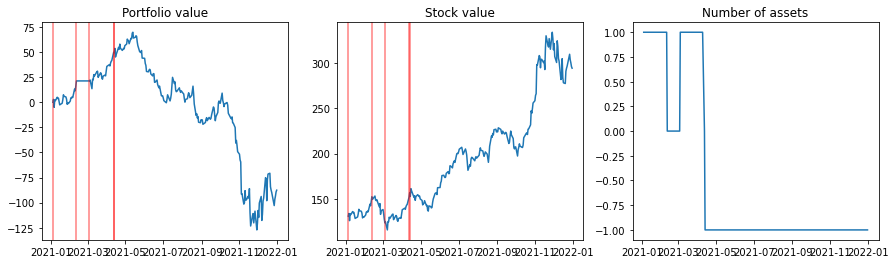

Final balance from GARCH strategy: -87.62870025634766


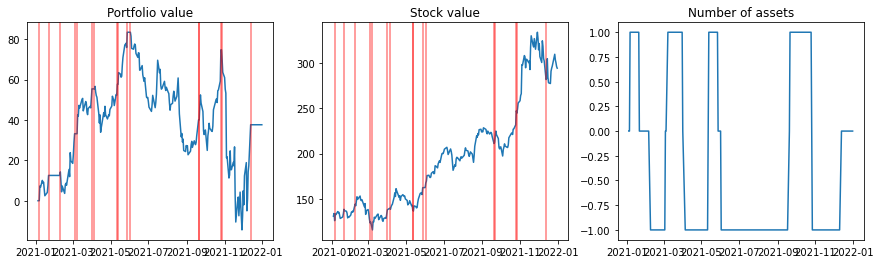

Final balance from standard strategy: 37.63258361816406
Chosen K: 4
Optimal parameters: [6.31825473e-01 1.00000000e-02 3.06879546e-01 1.35425246e-01
 3.23538294e-01 9.74195421e-02 1.00000000e-02 1.00000000e-05
 2.15833466e-02 1.00000000e-05 1.00000000e-05 9.27409903e+00]


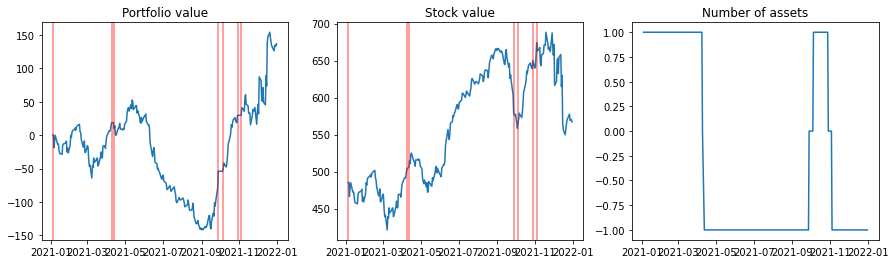

Final balance from GARCH strategy: 136.63998413085938


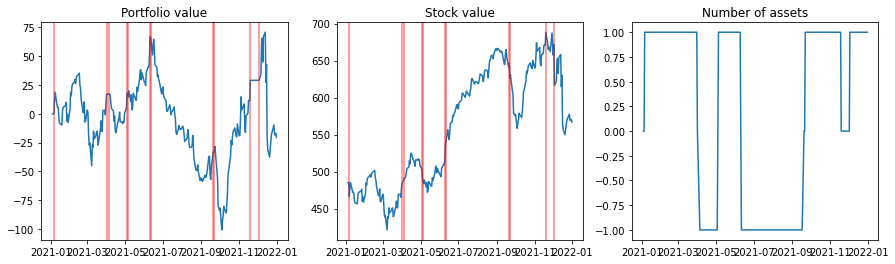

Final balance from standard strategy: -20.430023193359375
Chosen K: 2
Optimal parameters: [2.96779323e-01 1.00000000e-02 1.00000000e-05 1.00000000e-05
 1.00000000e-05 3.02704947e-02 1.00000000e-02 5.00000000e-01
 6.42142375e-03 7.32028302e-02 2.38800592e-01 7.22313226e+01]


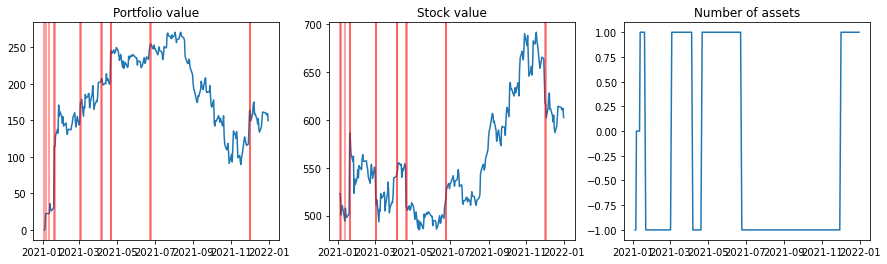

Final balance from GARCH strategy: 149.48007202148438


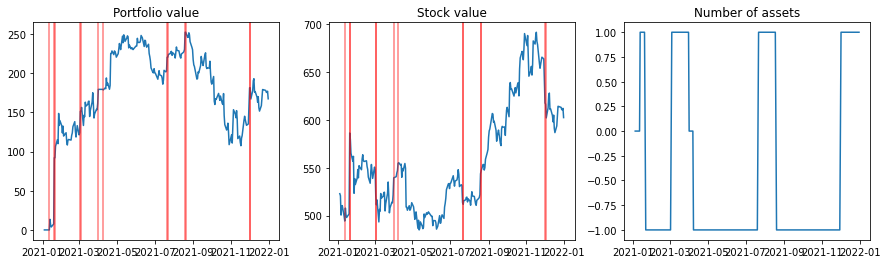

Final balance from standard strategy: 167.330078125
Chosen K: 3
Optimal parameters: [9.91644618e-01 2.94626924e-01 1.00000000e-05 1.00000000e-05
 1.00000000e-05 7.50204497e-02 1.00000000e-02 7.93327371e-02
 1.00000000e-05 1.48912537e-01 1.00000000e-05 1.97125331e+01]


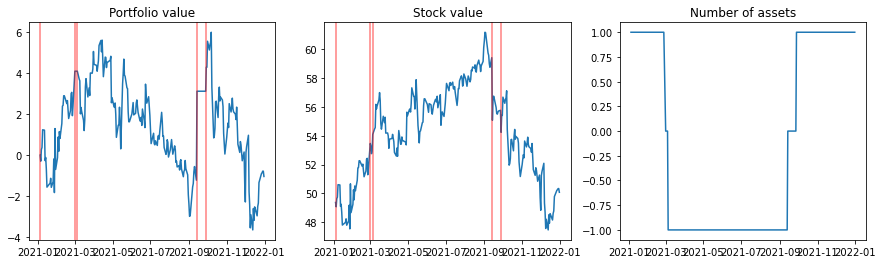

Final balance from GARCH strategy: -1.0404167175292969


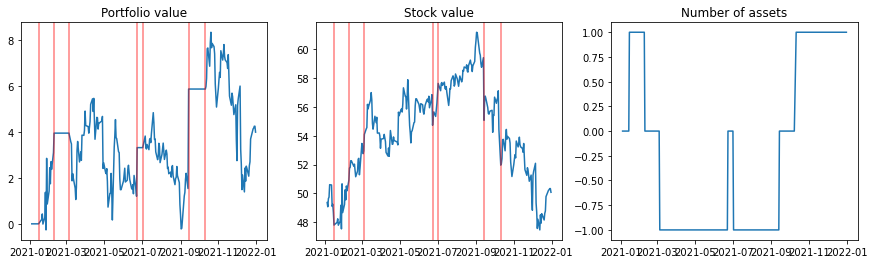

Final balance from standard strategy: 3.99993896484375
Strategy 2 with shorting with K optimization:
|    | Ticker   |   chosen K |   GARCH balance |   Standard balance |   Difference | Winner   |
|---:|:---------|-----------:|----------------:|-------------------:|-------------:|:---------|
|  0 | AAPL     |          2 |       -10.7387  |          -15.569   |      4.83029 | GARCH    |
|  1 | MSFT     |          2 |        24.0251  |           35.5403  |    -11.5152  | Standard |
|  2 | AMZN     |          2 |      1351.3     |         1235.45    |    115.85    | GARCH    |
|  3 | GOOGL    |          4 |      -475.46    |         -169.19    |   -306.27    | Standard |
|  4 | TSLA     |          3 |       267.15    |         -270.68    |    537.83    | GARCH    |
|  5 | INTC     |          4 |       -14.5722  |            1.64766 |    -16.2199  | Standard |
|  6 | NVDA     |          4 |       -87.6287  |           37.6326  |   -125.261   | Standard |
|  7 | ADBE     |          4 |     

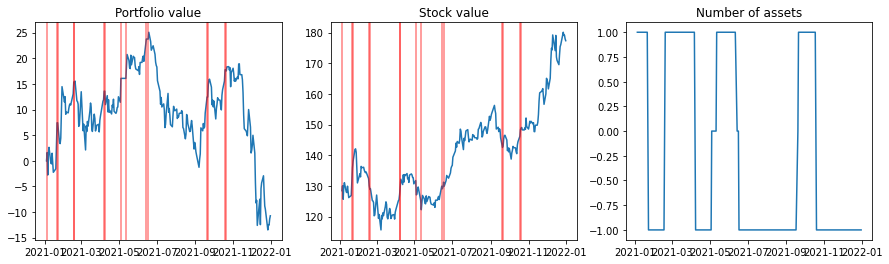

Final balance from GARCH strategy: -10.738677978515625


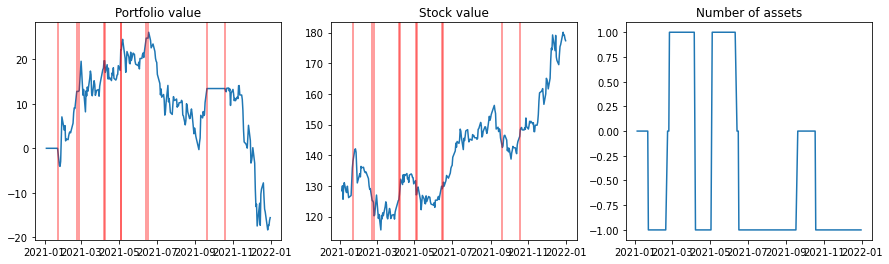

Final balance from standard strategy: -15.5689697265625
Chosen K: 2
Optimal parameters: [1.35801954e-01 1.00000000e-02 4.03317245e-02 1.00000000e-05
 3.29870717e-02 1.00000000e-05 1.00000000e-02 1.94756761e-01
 4.96010849e-01 1.00000000e-05 1.28105849e-01 1.11715398e+01]


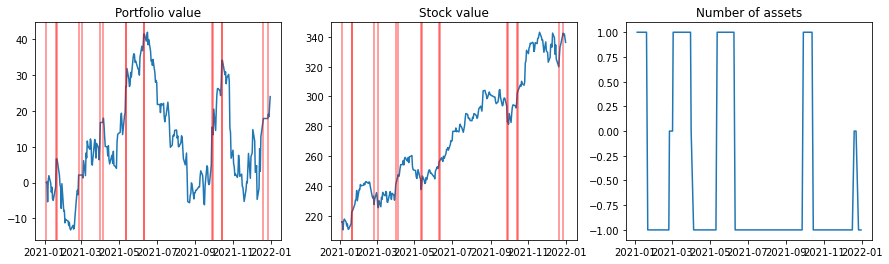

Final balance from GARCH strategy: 24.025146484375


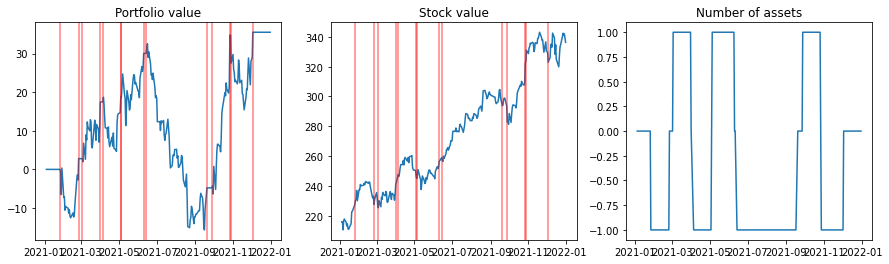

Final balance from standard strategy: 35.54034423828125
Chosen K: 2
Optimal parameters: [3.09466414e-01 1.00000000e-02 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 2.05692035e-02 4.92999008e-01
 1.00000000e-05 1.00000000e-05 3.36783096e-01 1.10325176e+01]


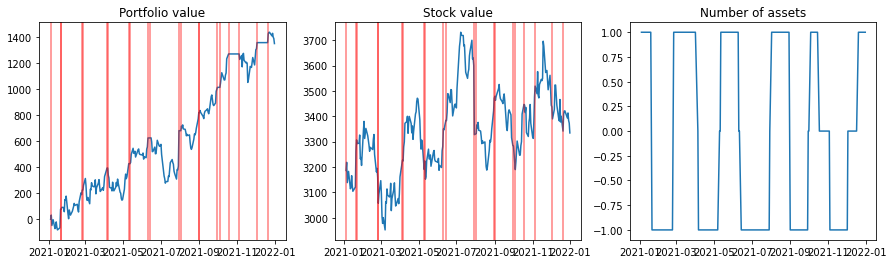

Final balance from GARCH strategy: 1351.300048828125


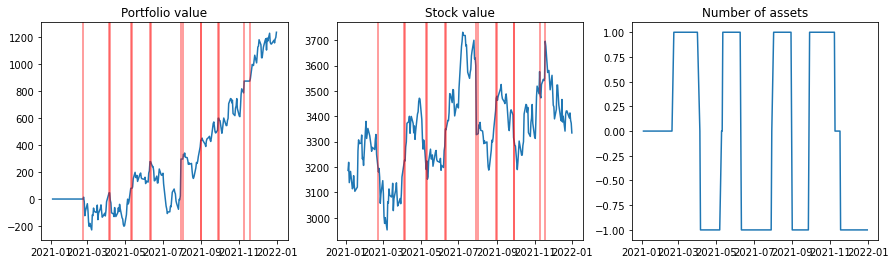

Final balance from standard strategy: 1235.449951171875
Chosen K: 2
Optimal parameters: [1.37077593e+00 9.51546242e-02 6.70368017e-02 1.33137783e-01
 1.00000000e-05 1.15506606e-01 1.00000000e-02 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 2.30324927e+00]


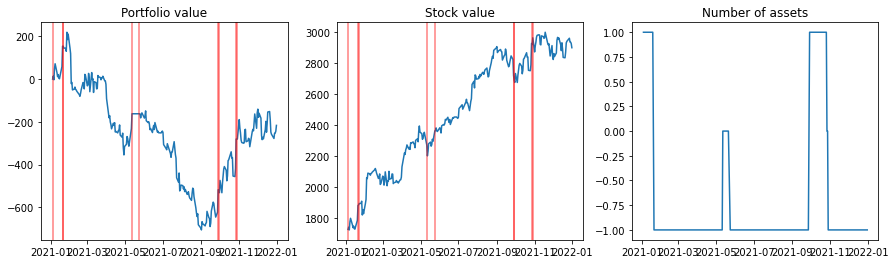

Final balance from GARCH strategy: -216.5601806640625


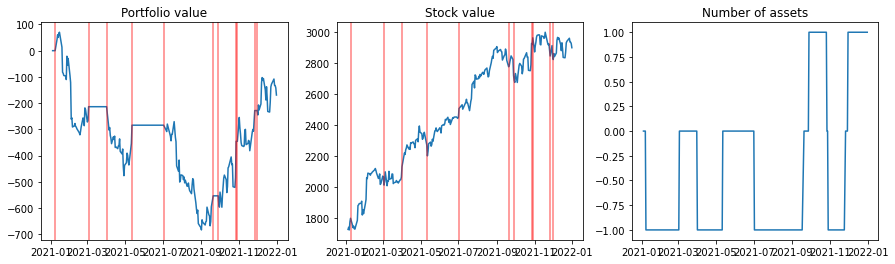

Final balance from standard strategy: -169.18994140625
Chosen K: 2
Optimal parameters: [2.00000000e+00 3.26745595e-01 1.00000000e-05 1.00000000e-05
 1.00000000e-05 5.55100940e-02 2.32212545e-01 1.00000000e-05
 1.00000000e-05 1.00000000e-05 2.53771009e-01 1.19961216e+01]


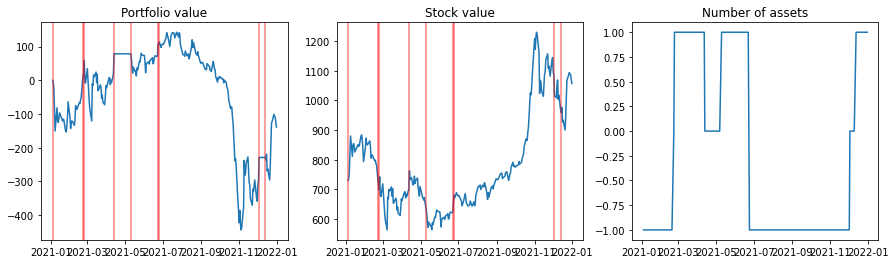

Final balance from GARCH strategy: -138.4998779296875


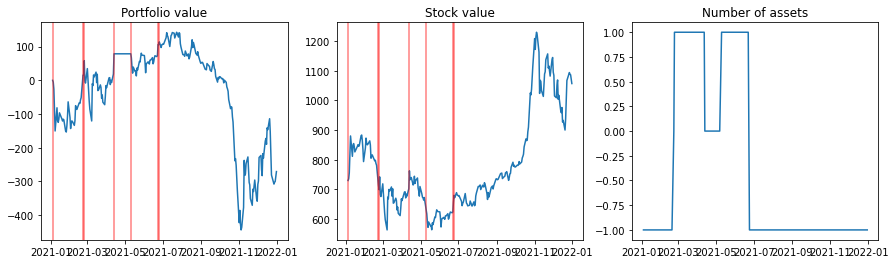

Final balance from standard strategy: -270.67999267578125
Chosen K: 2
Optimal parameters: [1.00956688e+00 1.95277955e-01 1.00000000e-05 1.00000000e-05
 1.00000000e-05 3.40394670e-01 3.25023348e-01 1.00000000e-05
 1.00000000e-05 1.00000000e-05 1.00000000e-05 9.76707298e-02]


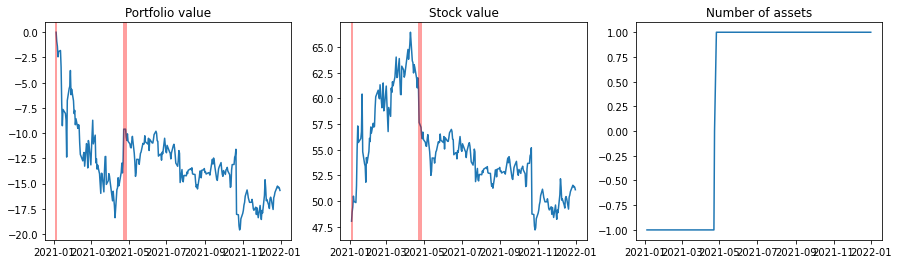

Final balance from GARCH strategy: -15.681697845458984


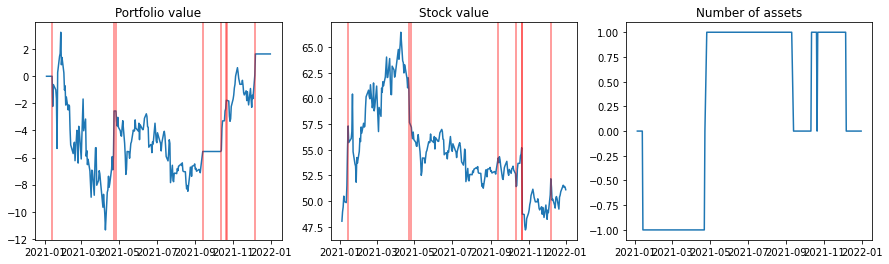

Final balance from standard strategy: 1.6476631164550781
Chosen K: 2
Optimal parameters: [1.90293392e+00 1.00000000e-02 1.00000000e-05 1.00000000e-05
 2.21240143e-01 1.00000000e-05 1.00000000e-02 9.54447373e-02
 4.21488346e-01 1.00000000e-05 1.00000000e-05 6.85414201e+01]


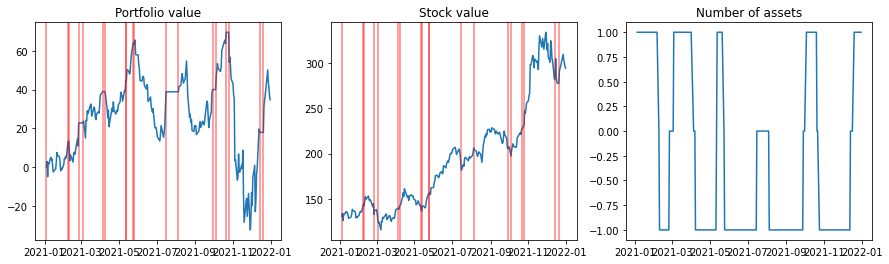

Final balance from GARCH strategy: 34.816627502441406


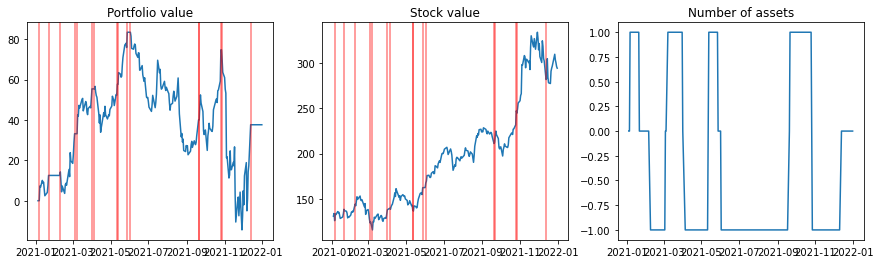

Final balance from standard strategy: 37.63258361816406
Chosen K: 2
Optimal parameters: [6.31825473e-01 1.00000000e-02 3.06879546e-01 1.35425246e-01
 3.23538294e-01 9.74195421e-02 1.00000000e-02 1.00000000e-05
 2.15833466e-02 1.00000000e-05 1.00000000e-05 9.27409903e+00]


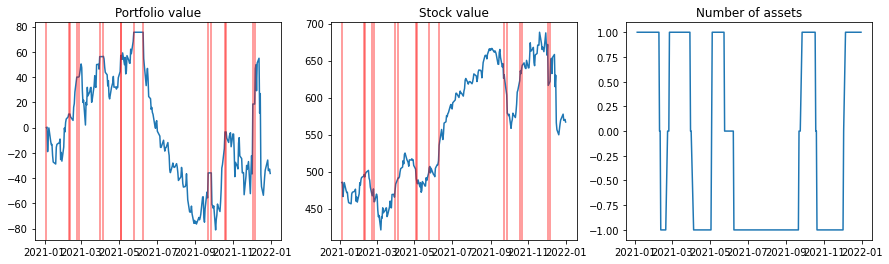

Final balance from GARCH strategy: -36.31011962890625


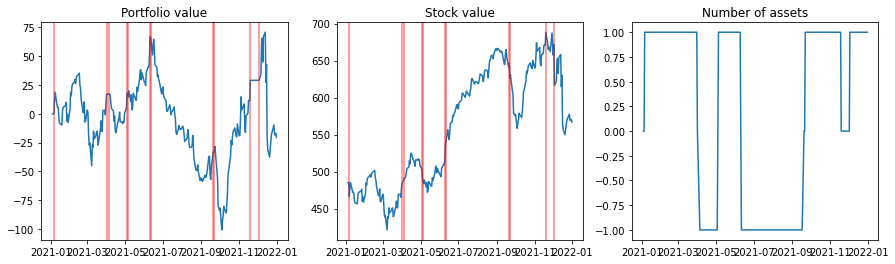

Final balance from standard strategy: -20.430023193359375
Chosen K: 2
Optimal parameters: [2.96779323e-01 1.00000000e-02 1.00000000e-05 1.00000000e-05
 1.00000000e-05 3.02704947e-02 1.00000000e-02 5.00000000e-01
 6.42142375e-03 7.32028302e-02 2.38800592e-01 7.22313226e+01]


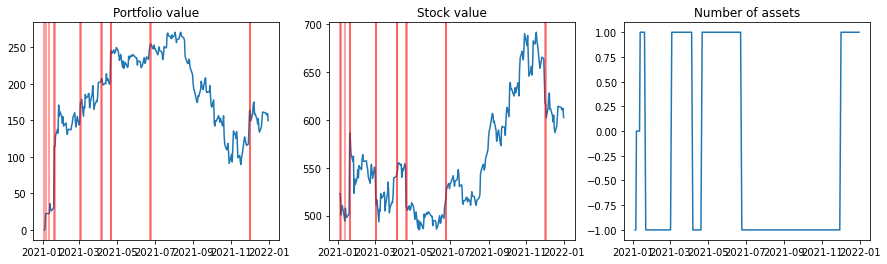

Final balance from GARCH strategy: 149.48007202148438


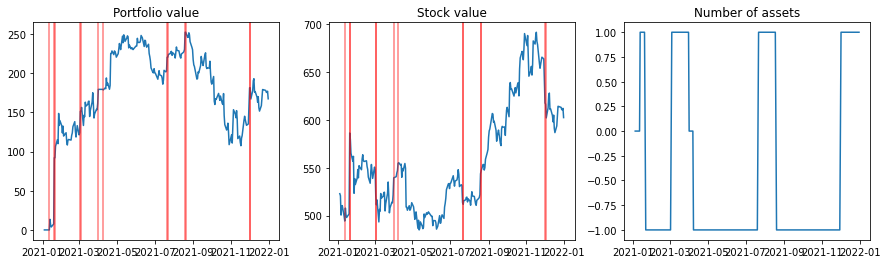

Final balance from standard strategy: 167.330078125
Chosen K: 2
Optimal parameters: [9.91644618e-01 2.94626924e-01 1.00000000e-05 1.00000000e-05
 1.00000000e-05 7.50204497e-02 1.00000000e-02 7.93327371e-02
 1.00000000e-05 1.48912537e-01 1.00000000e-05 1.97125331e+01]


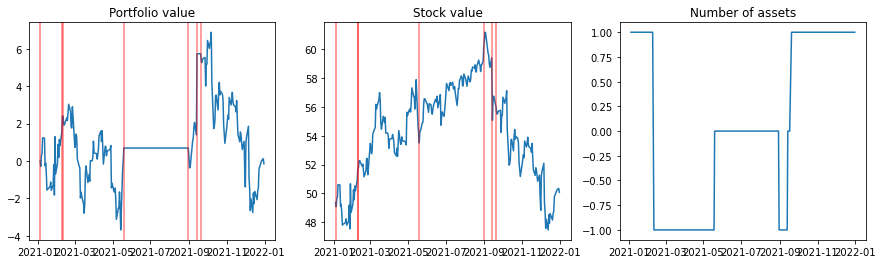

Final balance from GARCH strategy: -0.15076446533203125


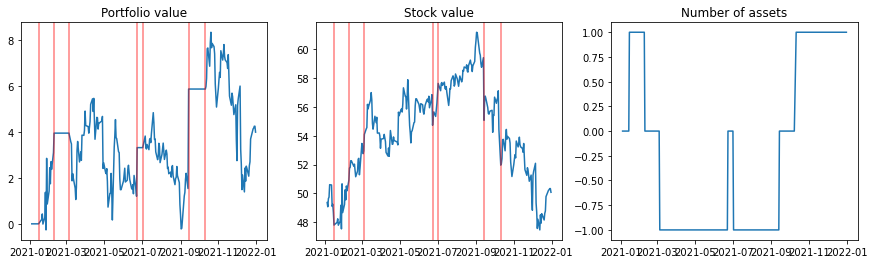

Final balance from standard strategy: 3.99993896484375
Strategy 2 with shorting with constant K =2:
| Ticker   | GARCH balance   | Standard balance   | Difference   | Winner   |
|----------|-----------------|--------------------|--------------|----------|
GARCH better 3 times, total difference: 0


In [ ]:

Bollinger_values = pd.DataFrame(columns=["Ticker","chosen K", "GARCH balance", "Standard balance", "Difference", "Winner"])
w = 0
for count, key in enumerate(NASDAQ.keys()):
    train_iter = NASDAQ[key][:datetime(year=2020,month=12,day=31)]
    test_iter = NASDAQ[key][datetime(year=2021,month=1,day=1):]
    K, fbg, fb = use_Bollinger(p,q,strategy2, train_data=train_iter, test_data = test_iter, short = True, verbose = False)
    if fbg > fb:
      win = 'GARCH'
      w +=1
    else:
      win = "Standard"
    Bollinger_values.loc[len(Bollinger_values)]=([key]+[K]+[fbg]+[fb]+ [fbg-fb] + [win])

print('Strategy 2 with shorting with K optimization:')
print(Bollinger_values.to_markdown()) 
print(f'GARCH better {w} times, total difference: {np.sum(Bollinger_values["Difference"])}')


Bollinger_values2 = pd.DataFrame(columns=["Ticker", "GARCH balance", "Standard balance", "Difference", "Winner"])
w = 0
for count, key in enumerate(NASDAQ.keys()):
    train_iter = NASDAQ[key][:datetime(year=2020,month=12,day=31)]
    test_iter = NASDAQ[key][datetime(year=2021,month=1,day=1):]
    K, fbg, fb = use_Bollinger(p,q,strategy2, train_data=train_iter, test_data = test_iter, short = True, verbose = False, K=2)
    if fbg > fb:
      win = 'GARCH'
      w +=1
    else:
      win = "Standard"
    Bollinger_values.loc[len(Bollinger_values)]=([key]+[K]+[fbg]+[fb]+ [fbg-fb] + [win])

print('Strategy 2 with shorting with constant K =2:')
print(Bollinger_values2.to_markdown()) 
print(f'GARCH better {w} times, total difference: {np.sum(Bollinger_values2["Difference"])}')

# Conclusions


---

As we can see GARCH model is a decent tool for future volatility predictions. Its main advantage is the fact that it captures the changing levels of stock's returns variances which are much more accurate than treating $\sigma^2$ as a constant especially in a long time distance.\
Based on our data we established that the best GARCH(p,q) model seems to be the one with $p=q=5$ which may be connected to the influence of the whole week rather than just one day before.\
When it comes to the Bollinger band- the certain thing is that in a world without transaction costs even the standard version of the strategy works quite fine. Our variation gave mixed results- some of them were significantly better than ones from the standard Bollinger band, but there is no certainity in it being better everytime. Nonetheless, our technic serves an interesting perspective on well-known strategy and should be considered as a starting point for further research.

In [ ]:
print("Thank you for your time.")